In [253]:
import pandas as pd
import numpy as np
import numbers
import plotly
from plotly.offline import iplot
import plotly.graph_objs as go
from sklearn.metrics import precision_recall_curve
from sklearn import metrics
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import copy
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score

In [254]:
pd.set_option('display.max_columns', None, 'display.width', -1)
gun_violence_df = pd.read_csv('gun-violence-data_01-2013_03-2018.csv')
gun_violence_df

,incident_id,date,state,city_or_county,address,n_killed,n_injured,incident_url,source_url,incident_url_fields_missing,congressional_district,gun_stolen,gun_type,incident_characteristics,latitude,location_description,longitude,n_guns_involved,notes,participant_age,participant_age_group,participant_gender,participant_name,participant_relationship,participant_status,participant_type,sources,state_house_district,state_senate_district
0,461105,2013-01-01,Pennsylvania,Mckeesport,1506 Versailles Avenue and Coursin Street,0,4,http://www.gunviolencearchive.org/incident/461105,http://www.post-gazette.com/local/south/2013/0...,False,14.0,NaN,NaN,Shot - Wounded/Injured||Mass Shooting (4+ vict...,40.3467,NaN,-79.8559,NaN,Julian Sims under investigation: Four Shot and...,0::20,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Male||1::Male||3::Male||4::Female,0::Julian Sims,NaN,0::Arrested||1::Injured||2::Injured||3::Injure...,0::Victim||1::Victim||2::Victim||3::Victim||4:...,http://pittsburgh.cbslocal.com/2013/01/01/4-pe...,NaN,NaN
1,460726,2013-01-01,California,Hawthorne,13500 block of Cerise Avenue,1,3,http://www.gunviolencearchive.org/incident/460726,http://www.dailybulletin.com/article/zz/201301...,False,43.0,NaN,NaN,"Shot - Wounded/Injured||Shot - Dead (murder, a...",33.9090,NaN,-118.3330,NaN,Four Shot; One Killed; Unidentified shooter in...,0::20,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Male,0::Bernard Gillis,NaN,0::Killed||1::Injured||2::Injured||3::Injured,0::Victim||1::Victim||2::Victim||3::Victim||4:...,http://losangeles.cbslocal.com/2013/01/01/man-...,62.0,35.0
2,478855,2013-01-01,Ohio,Lorain,1776 East 28th Street,1,3,http://www.gunviolencearchive.org/incident/478855,http://chronicle.northcoastnow.com/2013/02/14/...,False,9.0,0::Unknown||1::Unknown,0::Unknown||1::Unknown,"Shot - Wounded/Injured||Shot - Dead (murder, a...",41.4455,Cotton Club,-82.1377,2.0,NaN,0::25||1::31||2::33||3::34||4::33,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Male||1::Male||2::Male||3::Male||4::Male,0::Damien Bell||1::Desmen Noble||2::Herman Sea...,NaN,"0::Injured, Unharmed, Arrested||1::Unharmed, A...",0::Subject-Suspect||1::Subject-Suspect||2::Vic...,http://www.morningjournal.com/general-news/201...,56.0,13.0
3,478925,2013-01-05,Colorado,Aurora,16000 block of East Ithaca Place,4,0,http://www.gunviolencearchive.org/incident/478925,http://www.dailydemocrat.com/20130106/aurora-s...,False,6.0,NaN,NaN,"Shot - Dead (murder, accidental, suicide)||Off...",39.6518,NaN,-104.8020,NaN,NaN,0::29||1::33||2::56||3::33,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Female||1::Male||2::Male||3::Male,0::Stacie Philbrook||1::Christopher Ratliffe||...,NaN,0::Killed||1::Killed||2::Killed||3::Killed,0::Victim||1::Victim||2::Victim||3::Subject-Su...,http://denver.cbslocal.com/2013/01/06/officer-...,40.0,28.0
4,478959,2013-01-07,North Carolina,Greensboro,307 Mourning Dove Terrace,2,2,http://www.gunviolencearchive.org/incident/478959,http://www.journalnow.com/news/local/article_d...,False,6.0,0::Unknown||1::Unknown,0::Handgun||1::Handgun,"Shot - Wounded/Injured||Shot - Dead (murder, a...",36.1140,NaN,-79.9569,2.0,Two firearms recovered. (Attempted) murder sui...,0::18||1::46||2::14||3::47,0::Adult 18+||1::Adult 18+||2::Teen 12-17||3::...,0::Female||1::Male||2::Male||3::Female,0::Danielle Imani Jameison||1::Maurice Eugene ...,3::Family,0::Injured||1::Injured||2::Killed||3::Killed,0::Victim||1::Victim||2::Victim||3::Subject-Su...,http://myfox8.com/2013/01/08/update-mother-sho...,62.0,27.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239672,1083142,2018-03-31,Louisiana,Rayne,North Riceland Road and Highway 90,0,0,http://www.gunviolencearchive.org/incident/108...,http://www.klfy.com/news/local/rayne-woman-cha...,False,NaN,0::Unknown,0::Unknown,Shots Fired - No Injuries,NaN,NaN,NaN,1.0,NaN,0::25,0::Adult 18+,0::Female,0::Jhkeya Tezeno,NaN,"0::Unharmed, Arrested",0::Subject-Susp

In [255]:
# gun_violence_df.head(5).to_excel('firstLook.xlsx')

In [256]:
gun_violence_df['n_killed'].median()

0.0

In [257]:
gun_violence_df['n_injured'].median()

0.0

In [258]:
gun_violence_df['n_injured'].mean()

0.4940065171042695

In [259]:



# Function to describe more information for all the attributes
def brief(data):
    df = data.copy()

    print("This dataset has {} Rows {} Attributes".format(df.shape[0], df.shape[1]), end='')
    print('\n')

    real_valued = {}
    symbolics = {}

    for i, col in enumerate(df.columns, 1):
        Missing = len(df[col]) - df[col].count()

        counter = 0
        for val in df[col].dropna():
            if isinstance(val, numbers.Number):
                counter += 1

        if counter != len(df[col].dropna()):
            arity = len(df[col].dropna().unique())
            symbolics[i] = [i, col, Missing, arity]
        else:
            Mean, Median, Sdev, Min, Max = df[col].mean(), df[col].median(), df[col].std(), df[col].min(), df[col].max()
            real_valued[i] = [i, col, Missing, Mean, Median, Sdev, Min, Max]

    #Create array containing list of real valued
    real_valued_array = [real_valued[keys] for keys in real_valued.keys()]
    real_valued_transformed = np.array(real_valued_array).T

    symbolic_array = [symbolics[keys] for keys in symbolics.keys()]
    symbolic_transformed = np.array(symbolic_array).T

    # return symbolic_transformed
    real_cols = ['Attribute_ID', 'Attribute_Name', 'Missing', 'Mean', 'Median', 'Sdev', 'Min', 'Max']
    sym_cols = ['Attribute_ID', 'Attribute_Name', 'Missing', 'arity']

    index = range(1, len(real_valued.keys()) + 1)
    real_val_df = pd.DataFrame(data={unit[0]: unit[1] for unit in zip(real_cols, real_valued_transformed)}, index=index,
                               columns=real_cols)

    index_sym = range(1, len(symbolics.keys()) + 1)
    sym_val_df = pd.DataFrame(data={unit[0]: unit[1] for unit in zip(sym_cols, symbolic_transformed)}, index=index_sym,
                              columns=sym_cols)

    text = ("real valued attributes" + "\n" + "---------------------"
            + "\n" + str(real_val_df) + "\n" + "non-real valued attributes"
            + "\n" + "-------------------" + "\n" + str(sym_val_df))

    return text

In [260]:
print(brief(gun_violence_df))

This dataset has 239677 Rows 29 Attributes

real valued attributes
---------------------
   Attribute_ID  \
1             1   
2             6   
3             7   
4            10   
5            11   
6            15   
7            17   
8            18   
9            28   
10           29   

                 Attribute_Name  \
1                   incident_id   
2                      n_killed   
3                     n_injured   
4   incident_url_fields_missing   
5        congressional_district   
6                      latitude   
7                     longitude   
8               n_guns_involved   
9          state_house_district   
10        state_senate_district   

   Missing  \
1        0   
2        0   
3        0   
4        0   
5    11944   
6     7923   
7     7923   
8    99451   
9    38772   
10   32335   

                   Mean  \
1     559334.3464037017   
2   0.25228953967214207   
3    0.4940065171042695   
4                   0.0   
5     8.001264638853394  

In [261]:
gun_violence_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 239677 entries, 0 to 239676
Data columns (total 29 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   incident_id                  239677 non-null  int64  
 1   date                         239677 non-null  object 
 2   state                        239677 non-null  object 
 3   city_or_county               239677 non-null  object 
 4   address                      223180 non-null  object 
 5   n_killed                     239677 non-null  int64  
 6   n_injured                    239677 non-null  int64  
 7   incident_url                 239677 non-null  object 
 8   source_url                   239209 non-null  object 
 9   incident_url_fields_missing  239677 non-null  bool   
 10  congressional_district       227733 non-null  float64
 11  gun_stolen                   140179 non-null  object 
 12  gun_type                     140226 non-null  object 
 13 

In [262]:
# f = open("info", "w")
# f.write(gun_violence_df.info())
# f.close()

In [263]:
gun_violence_df = gun_violence_df.dropna(subset='n_killed')
gun_violence_df

,incident_id,date,state,city_or_county,address,n_killed,n_injured,incident_url,source_url,incident_url_fields_missing,congressional_district,gun_stolen,gun_type,incident_characteristics,latitude,location_description,longitude,n_guns_involved,notes,participant_age,participant_age_group,participant_gender,participant_name,participant_relationship,participant_status,participant_type,sources,state_house_district,state_senate_district
0,461105,2013-01-01,Pennsylvania,Mckeesport,1506 Versailles Avenue and Coursin Street,0,4,http://www.gunviolencearchive.org/incident/461105,http://www.post-gazette.com/local/south/2013/0...,False,14.0,NaN,NaN,Shot - Wounded/Injured||Mass Shooting (4+ vict...,40.3467,NaN,-79.8559,NaN,Julian Sims under investigation: Four Shot and...,0::20,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Male||1::Male||3::Male||4::Female,0::Julian Sims,NaN,0::Arrested||1::Injured||2::Injured||3::Injure...,0::Victim||1::Victim||2::Victim||3::Victim||4:...,http://pittsburgh.cbslocal.com/2013/01/01/4-pe...,NaN,NaN
1,460726,2013-01-01,California,Hawthorne,13500 block of Cerise Avenue,1,3,http://www.gunviolencearchive.org/incident/460726,http://www.dailybulletin.com/article/zz/201301...,False,43.0,NaN,NaN,"Shot - Wounded/Injured||Shot - Dead (murder, a...",33.9090,NaN,-118.3330,NaN,Four Shot; One Killed; Unidentified shooter in...,0::20,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Male,0::Bernard Gillis,NaN,0::Killed||1::Injured||2::Injured||3::Injured,0::Victim||1::Victim||2::Victim||3::Victim||4:...,http://losangeles.cbslocal.com/2013/01/01/man-...,62.0,35.0
2,478855,2013-01-01,Ohio,Lorain,1776 East 28th Street,1,3,http://www.gunviolencearchive.org/incident/478855,http://chronicle.northcoastnow.com/2013/02/14/...,False,9.0,0::Unknown||1::Unknown,0::Unknown||1::Unknown,"Shot - Wounded/Injured||Shot - Dead (murder, a...",41.4455,Cotton Club,-82.1377,2.0,NaN,0::25||1::31||2::33||3::34||4::33,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Male||1::Male||2::Male||3::Male||4::Male,0::Damien Bell||1::Desmen Noble||2::Herman Sea...,NaN,"0::Injured, Unharmed, Arrested||1::Unharmed, A...",0::Subject-Suspect||1::Subject-Suspect||2::Vic...,http://www.morningjournal.com/general-news/201...,56.0,13.0
3,478925,2013-01-05,Colorado,Aurora,16000 block of East Ithaca Place,4,0,http://www.gunviolencearchive.org/incident/478925,http://www.dailydemocrat.com/20130106/aurora-s...,False,6.0,NaN,NaN,"Shot - Dead (murder, accidental, suicide)||Off...",39.6518,NaN,-104.8020,NaN,NaN,0::29||1::33||2::56||3::33,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Female||1::Male||2::Male||3::Male,0::Stacie Philbrook||1::Christopher Ratliffe||...,NaN,0::Killed||1::Killed||2::Killed||3::Killed,0::Victim||1::Victim||2::Victim||3::Subject-Su...,http://denver.cbslocal.com/2013/01/06/officer-...,40.0,28.0
4,478959,2013-01-07,North Carolina,Greensboro,307 Mourning Dove Terrace,2,2,http://www.gunviolencearchive.org/incident/478959,http://www.journalnow.com/news/local/article_d...,False,6.0,0::Unknown||1::Unknown,0::Handgun||1::Handgun,"Shot - Wounded/Injured||Shot - Dead (murder, a...",36.1140,NaN,-79.9569,2.0,Two firearms recovered. (Attempted) murder sui...,0::18||1::46||2::14||3::47,0::Adult 18+||1::Adult 18+||2::Teen 12-17||3::...,0::Female||1::Male||2::Male||3::Female,0::Danielle Imani Jameison||1::Maurice Eugene ...,3::Family,0::Injured||1::Injured||2::Killed||3::Killed,0::Victim||1::Victim||2::Victim||3::Subject-Su...,http://myfox8.com/2013/01/08/update-mother-sho...,62.0,27.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239672,1083142,2018-03-31,Louisiana,Rayne,North Riceland Road and Highway 90,0,0,http://www.gunviolencearchive.org/incident/108...,http://www.klfy.com/news/local/rayne-woman-cha...,False,NaN,0::Unknown,0::Unknown,Shots Fired - No Injuries,NaN,NaN,NaN,1.0,NaN,0::25,0::Adult 18+,0::Female,0::Jhkeya Tezeno,NaN,"0::Unharmed, Arrested",0::Subject-Susp

In [264]:
gun_violence_df = gun_violence_df.dropna(subset='n_injured')
gun_violence_df

,incident_id,date,state,city_or_county,address,n_killed,n_injured,incident_url,source_url,incident_url_fields_missing,congressional_district,gun_stolen,gun_type,incident_characteristics,latitude,location_description,longitude,n_guns_involved,notes,participant_age,participant_age_group,participant_gender,participant_name,participant_relationship,participant_status,participant_type,sources,state_house_district,state_senate_district
0,461105,2013-01-01,Pennsylvania,Mckeesport,1506 Versailles Avenue and Coursin Street,0,4,http://www.gunviolencearchive.org/incident/461105,http://www.post-gazette.com/local/south/2013/0...,False,14.0,NaN,NaN,Shot - Wounded/Injured||Mass Shooting (4+ vict...,40.3467,NaN,-79.8559,NaN,Julian Sims under investigation: Four Shot and...,0::20,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Male||1::Male||3::Male||4::Female,0::Julian Sims,NaN,0::Arrested||1::Injured||2::Injured||3::Injure...,0::Victim||1::Victim||2::Victim||3::Victim||4:...,http://pittsburgh.cbslocal.com/2013/01/01/4-pe...,NaN,NaN
1,460726,2013-01-01,California,Hawthorne,13500 block of Cerise Avenue,1,3,http://www.gunviolencearchive.org/incident/460726,http://www.dailybulletin.com/article/zz/201301...,False,43.0,NaN,NaN,"Shot - Wounded/Injured||Shot - Dead (murder, a...",33.9090,NaN,-118.3330,NaN,Four Shot; One Killed; Unidentified shooter in...,0::20,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Male,0::Bernard Gillis,NaN,0::Killed||1::Injured||2::Injured||3::Injured,0::Victim||1::Victim||2::Victim||3::Victim||4:...,http://losangeles.cbslocal.com/2013/01/01/man-...,62.0,35.0
2,478855,2013-01-01,Ohio,Lorain,1776 East 28th Street,1,3,http://www.gunviolencearchive.org/incident/478855,http://chronicle.northcoastnow.com/2013/02/14/...,False,9.0,0::Unknown||1::Unknown,0::Unknown||1::Unknown,"Shot - Wounded/Injured||Shot - Dead (murder, a...",41.4455,Cotton Club,-82.1377,2.0,NaN,0::25||1::31||2::33||3::34||4::33,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Male||1::Male||2::Male||3::Male||4::Male,0::Damien Bell||1::Desmen Noble||2::Herman Sea...,NaN,"0::Injured, Unharmed, Arrested||1::Unharmed, A...",0::Subject-Suspect||1::Subject-Suspect||2::Vic...,http://www.morningjournal.com/general-news/201...,56.0,13.0
3,478925,2013-01-05,Colorado,Aurora,16000 block of East Ithaca Place,4,0,http://www.gunviolencearchive.org/incident/478925,http://www.dailydemocrat.com/20130106/aurora-s...,False,6.0,NaN,NaN,"Shot - Dead (murder, accidental, suicide)||Off...",39.6518,NaN,-104.8020,NaN,NaN,0::29||1::33||2::56||3::33,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Female||1::Male||2::Male||3::Male,0::Stacie Philbrook||1::Christopher Ratliffe||...,NaN,0::Killed||1::Killed||2::Killed||3::Killed,0::Victim||1::Victim||2::Victim||3::Subject-Su...,http://denver.cbslocal.com/2013/01/06/officer-...,40.0,28.0
4,478959,2013-01-07,North Carolina,Greensboro,307 Mourning Dove Terrace,2,2,http://www.gunviolencearchive.org/incident/478959,http://www.journalnow.com/news/local/article_d...,False,6.0,0::Unknown||1::Unknown,0::Handgun||1::Handgun,"Shot - Wounded/Injured||Shot - Dead (murder, a...",36.1140,NaN,-79.9569,2.0,Two firearms recovered. (Attempted) murder sui...,0::18||1::46||2::14||3::47,0::Adult 18+||1::Adult 18+||2::Teen 12-17||3::...,0::Female||1::Male||2::Male||3::Female,0::Danielle Imani Jameison||1::Maurice Eugene ...,3::Family,0::Injured||1::Injured||2::Killed||3::Killed,0::Victim||1::Victim||2::Victim||3::Subject-Su...,http://myfox8.com/2013/01/08/update-mother-sho...,62.0,27.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239672,1083142,2018-03-31,Louisiana,Rayne,North Riceland Road and Highway 90,0,0,http://www.gunviolencearchive.org/incident/108...,http://www.klfy.com/news/local/rayne-woman-cha...,False,NaN,0::Unknown,0::Unknown,Shots Fired - No Injuries,NaN,NaN,NaN,1.0,NaN,0::25,0::Adult 18+,0::Female,0::Jhkeya Tezeno,NaN,"0::Unharmed, Arrested",0::Subject-Susp

In [265]:
gun_violence_df.drop_duplicates()

,incident_id,date,state,city_or_county,address,n_killed,n_injured,incident_url,source_url,incident_url_fields_missing,congressional_district,gun_stolen,gun_type,incident_characteristics,latitude,location_description,longitude,n_guns_involved,notes,participant_age,participant_age_group,participant_gender,participant_name,participant_relationship,participant_status,participant_type,sources,state_house_district,state_senate_district
0,461105,2013-01-01,Pennsylvania,Mckeesport,1506 Versailles Avenue and Coursin Street,0,4,http://www.gunviolencearchive.org/incident/461105,http://www.post-gazette.com/local/south/2013/0...,False,14.0,NaN,NaN,Shot - Wounded/Injured||Mass Shooting (4+ vict...,40.3467,NaN,-79.8559,NaN,Julian Sims under investigation: Four Shot and...,0::20,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Male||1::Male||3::Male||4::Female,0::Julian Sims,NaN,0::Arrested||1::Injured||2::Injured||3::Injure...,0::Victim||1::Victim||2::Victim||3::Victim||4:...,http://pittsburgh.cbslocal.com/2013/01/01/4-pe...,NaN,NaN
1,460726,2013-01-01,California,Hawthorne,13500 block of Cerise Avenue,1,3,http://www.gunviolencearchive.org/incident/460726,http://www.dailybulletin.com/article/zz/201301...,False,43.0,NaN,NaN,"Shot - Wounded/Injured||Shot - Dead (murder, a...",33.9090,NaN,-118.3330,NaN,Four Shot; One Killed; Unidentified shooter in...,0::20,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Male,0::Bernard Gillis,NaN,0::Killed||1::Injured||2::Injured||3::Injured,0::Victim||1::Victim||2::Victim||3::Victim||4:...,http://losangeles.cbslocal.com/2013/01/01/man-...,62.0,35.0
2,478855,2013-01-01,Ohio,Lorain,1776 East 28th Street,1,3,http://www.gunviolencearchive.org/incident/478855,http://chronicle.northcoastnow.com/2013/02/14/...,False,9.0,0::Unknown||1::Unknown,0::Unknown||1::Unknown,"Shot - Wounded/Injured||Shot - Dead (murder, a...",41.4455,Cotton Club,-82.1377,2.0,NaN,0::25||1::31||2::33||3::34||4::33,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Male||1::Male||2::Male||3::Male||4::Male,0::Damien Bell||1::Desmen Noble||2::Herman Sea...,NaN,"0::Injured, Unharmed, Arrested||1::Unharmed, A...",0::Subject-Suspect||1::Subject-Suspect||2::Vic...,http://www.morningjournal.com/general-news/201...,56.0,13.0
3,478925,2013-01-05,Colorado,Aurora,16000 block of East Ithaca Place,4,0,http://www.gunviolencearchive.org/incident/478925,http://www.dailydemocrat.com/20130106/aurora-s...,False,6.0,NaN,NaN,"Shot - Dead (murder, accidental, suicide)||Off...",39.6518,NaN,-104.8020,NaN,NaN,0::29||1::33||2::56||3::33,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Female||1::Male||2::Male||3::Male,0::Stacie Philbrook||1::Christopher Ratliffe||...,NaN,0::Killed||1::Killed||2::Killed||3::Killed,0::Victim||1::Victim||2::Victim||3::Subject-Su...,http://denver.cbslocal.com/2013/01/06/officer-...,40.0,28.0
4,478959,2013-01-07,North Carolina,Greensboro,307 Mourning Dove Terrace,2,2,http://www.gunviolencearchive.org/incident/478959,http://www.journalnow.com/news/local/article_d...,False,6.0,0::Unknown||1::Unknown,0::Handgun||1::Handgun,"Shot - Wounded/Injured||Shot - Dead (murder, a...",36.1140,NaN,-79.9569,2.0,Two firearms recovered. (Attempted) murder sui...,0::18||1::46||2::14||3::47,0::Adult 18+||1::Adult 18+||2::Teen 12-17||3::...,0::Female||1::Male||2::Male||3::Female,0::Danielle Imani Jameison||1::Maurice Eugene ...,3::Family,0::Injured||1::Injured||2::Killed||3::Killed,0::Victim||1::Victim||2::Victim||3::Subject-Su...,http://myfox8.com/2013/01/08/update-mother-sho...,62.0,27.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239672,1083142,2018-03-31,Louisiana,Rayne,North Riceland Road and Highway 90,0,0,http://www.gunviolencearchive.org/incident/108...,http://www.klfy.com/news/local/rayne-woman-cha...,False,NaN,0::Unknown,0::Unknown,Shots Fired - No Injuries,NaN,NaN,NaN,1.0,NaN,0::25,0::Adult 18+,0::Female,0::Jhkeya Tezeno,NaN,"0::Unharmed, Arrested",0::Subject-Susp

In [266]:
gun_violence_df['date'] = pd.to_datetime(gun_violence_df['date'])
gun_violence_filtered = gun_violence_df.assign(year=gun_violence_df['date'].map(lambda dates: dates.year))
gun_violence_filtered = gun_violence_filtered.assign(month=gun_violence_filtered['date'].map(lambda dates: dates.month))
gun_violence_filtered = gun_violence_filtered.assign(
    day=gun_violence_filtered['date'].map(lambda dates: dates.weekday()))

y_yrs = gun_violence_filtered.groupby('year')['incident_id'].count().values
x_yrs = gun_violence_filtered.groupby('year')['incident_id'].count().index.values

y_months = gun_violence_filtered.groupby(by=['year', 'month']).agg('count').groupby('month')[
    'incident_id'].mean().values

x_months = ['Янв', 'Февр', 'Март', 'Апр', 'Май', 'Июнь', 'Июль', 'Авг', 'Сент', 'Окт', 'Нояб', 'Дек']

y_days = gun_violence_filtered.groupby(['year', 'day']).agg('count').groupby('day')['incident_id'].mean().values

x_days = ['Пон', 'Втор', 'Сред', 'Четв', 'Пятн', 'Субб', 'Воскр']

trace1 = go.Bar(
    x=x_yrs,
    y=y_yrs
)
trace2 = go.Bar(
    x=x_months,
    y=y_months,
    xaxis='x2',
    yaxis='y2'
)
trace3 = go.Bar(
    x=x_days,
    y=y_days,
    xaxis='x3',
    yaxis='y3'
)

data = [trace1, trace2, trace3]
fig = plotly.tools.make_subplots(rows=3, cols=1, specs=[[{}], [{}], [{}]], vertical_spacing=0.25,
                                 subplot_titles=('Количество инцидентов в год',
                                                 'Среднее количество инцидентов в месяц',
                                                 'Среднее количество инцидентов в день'))

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 2, 1)
fig.append_trace(trace3, 3, 1)

fig['layout']['xaxis1'].update(title='Года')
fig['layout']['xaxis2'].update(title='Месяцы')
fig['layout']['xaxis3'].update(title='Дни')

fig['layout']['yaxis1'].update(title='Count')
fig['layout']['yaxis2'].update(title='Avg. Frequency')
fig['layout']['yaxis3'].update(title='Avg. Frequency')

fig['layout'].update(showlegend=False, height=800, width=800, title='Incidents Over Time')
iplot(fig)

/Users/denisserbin/PycharmProjects/nmla_lab1_serbin/venv/lib/python3.8/site-packages/plotly/tools.py:460: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



In [267]:
n_killed = gun_violence_filtered.groupby('date').sum()['n_killed'].values

n_injured = gun_violence_filtered.groupby('date').sum()['n_injured'].values

dates = gun_violence_filtered.groupby('date').count().index

x_months = ['Янв', 'Февр', 'Март', 'Апр', 'Май', 'Июнь', 'Июль', 'Авг', 'Сент', 'Окт', 'Нояб', 'Дек']

trace1 = go.Scatter(
    x=dates,
    y=n_killed,
    name='Количество убитых',
    line=dict(
        dash='dot'
    )
)

trace2 = go.Scatter(
    x=dates,
    y=n_injured,
    name='Количество раненных',
    line=dict(
        dash='dot'
    )
)

data = [trace1, trace2]

layout = dict(
    height=400,
    width=1000,
    title='Количество инцидентов',
    xaxis=dict(title='Time'),
    yaxis=dict(title='Count'),
)

fig = dict(data=data, layout=layout)
iplot(fig)

# 2014 time series
temp = gun_violence_filtered[gun_violence_filtered['year'] == 2014].groupby('date').agg(
    {'state': 'count', 'n_killed': 'sum', 'n_injured': 'sum'}).reset_index().rename(columns={'state': 'incidents'})

trace1 = go.Scatter(
    x=temp.date,
    y=temp.incidents,
    name='Количество инцидентов',
    mode="lines",
    marker=dict(color='#c5d9f9')

)
trace2 = go.Scatter(
    x=temp.date,
    y=temp.n_killed,
    name="Количество убитых",
    mode="lines",
    marker=dict(color='#ff9f87')
)

trace3 = go.Scatter(
    x=temp.date,
    y=temp.n_injured,
    name="Количество раненных",
    mode="lines",
    marker=dict(color='#e8baff')
)
print("2014")
print(f"Среднее количество инцидентов: {temp.incidents.mean()}")
print(f"Среднее количество убитых:     {temp.n_killed.mean()}")
print(f"Среднее количество раненных:   {temp.n_injured.mean()}")
data = [trace1, trace2, trace3]
layout = dict(
    height=350,
    title='Инциденты за 2014',
    legend=dict(
        orientation="h",
        x=-.01,
        y=1
    ),
    xaxis=dict(
        title='Временной ряд',
        ticklen=1
    )
)

fig = dict(data=data, layout=layout)
iplot(fig)

# 2015 time series
temp = gun_violence_filtered[gun_violence_filtered['year'] == 2015].groupby('date').agg(
    {'state': 'count', 'n_killed': 'sum', 'n_injured': 'sum'}).reset_index().rename(columns={'state': 'incidents'})

trace1 = go.Scatter(
    x=temp.date,
    y=temp.incidents,
    name='Количество инцидентов',
    mode="lines",
    marker=dict(color='#c5d9f9')
)

trace2 = go.Scatter(
    x=temp.date,
    y=temp.n_killed,
    name="Количество убитых",
    mode="lines",
    marker=dict(color='#ff9f87')
)

trace3 = go.Scatter(
    x=temp.date,
    y=temp.n_injured,
    name="Количество раненных",
    mode="lines",
    marker=dict(color='#e8baff')
)
print("2015")
print(f"Среднее количество инцидентов: {temp.incidents.mean()}")
print(f"Среднее количество убитых:     {temp.n_killed.mean()}")
print(f"Среднее количество раненных:   {temp.n_injured.mean()}")
data = [trace1, trace2, trace3]

layout = dict(
    height=350,
    title='Инциденты за 2015',
    legend=dict(
        orientation="h",
        x=-.01,
        y=1
    ),
    xaxis=dict(
        title='Временной ряд',
        ticklen=1
    )
)

fig = dict(data=data, layout=layout)
iplot(fig)

# 2016 time series
temp = gun_violence_filtered[gun_violence_filtered['year'] == 2016].groupby('date').agg(
    {'state': 'count', 'n_killed': 'sum', 'n_injured': 'sum'}).reset_index().rename(columns={'state': 'incidents'})

trace1 = go.Scatter(
    x=temp.date,
    y=temp.incidents,
    name='Количество инцидентов',
    mode="lines",
    marker=dict(color='#c5d9f9')
)

trace2 = go.Scatter(
    x=temp.date,
    y=temp.n_killed,
    name="Количество убитых",
    mode="lines",
    marker=dict(color='#ff9f87')
)

trace3 = go.Scatter(
    x=temp.date,
    y=temp.n_injured,
    name="Количество раненных",
    mode="lines",
    marker=dict(color='#e8baff')
)
print("2016")
print(f"Среднее количество инцидентов: {temp.incidents.mean()}")
print(f"Среднее количество убитых:     {temp.n_killed.mean()}")
print(f"Среднее количество раненных:   {temp.n_injured.mean()}")
data = [trace1, trace2, trace3]
layout = dict(
    height=350,
    title='Инциденты за 2016',
    legend=dict(
        orientation="h",
        x=-.01,
        y=1
    ),
    xaxis=dict(
        title='Временной ряд',
        ticklen=1)
)

fig = dict(data=data, layout=layout)
iplot(fig)

# 2017 time series
temp = gun_violence_filtered[gun_violence_filtered['year'] == 2017].groupby('date').agg(
    {'state': 'count', 'n_killed': 'sum', 'n_injured': 'sum'}).reset_index().rename(columns={'state': 'incidents'})

trace1 = go.Scatter(
    x=temp.date,
    y=temp.incidents,
    name='Количество инцидентов',
    mode="lines",
    marker=dict(color='#c5d9f9')
)
print(f"temp.date: {temp.date}")
trace2 = go.Scatter(
    x=temp.date,
    y=temp.n_killed,
    name="Количество убитых",
    mode="lines",
    marker=dict(color='#ff9f87')
)

trace3 = go.Scatter(
    x=temp.date,
    y=temp.n_injured,
    name="Количество раненных",
    mode="lines",
    marker=dict(color='#e8baff')
)
print("2017")
print(f"Среднее количество инцидентов: {temp.incidents.mean()}")
print(f"Среднее количество убитых:     {temp.n_killed.mean()}")
print(f"Среднее количество раненных:   {temp.n_injured.mean()}")
data = [trace1, trace2, trace3]
layout = dict(
    height=400,
    title='Инциденты за 2017',
    legend=dict(
        orientation="h",
        x=-.01, y=1
    ),
    xaxis=dict(
        title='Временной ряд',
        ticklen=1
    )
)

fig = dict(data=data, layout=layout)
iplot(fig)

/var/folders/cs/rdytcwcn26gglq1gv10mb7x80000gn/T/ipykernel_9845/89983871.py:1: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.

/var/folders/cs/rdytcwcn26gglq1gv10mb7x80000gn/T/ipykernel_9845/89983871.py:3: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



2014
Среднее количество инцидентов: 142.06575342465754
Среднее количество убитых:     34.4027397260274
Среднее количество раненных:   63.01917808219178


2015
Среднее количество инцидентов: 147.19505494505495
Среднее количество убитых:     37.043956043956044
Среднее количество раненных:   74.08516483516483


2016
Среднее количество инцидентов: 160.9945205479452
Среднее количество убитых:     41.276712328767125
Среднее количество раненных:   83.78082191780823


temp.date: 0     2017-01-01
1     2017-01-02
2     2017-01-03
3     2017-01-04
4     2017-01-05
         ...    
359   2017-12-27
360   2017-12-28
361   2017-12-29
362   2017-12-30
363   2017-12-31
Name: date, Length: 364, dtype: datetime64[ns]
2017
Среднее количество инцидентов: 168.68406593406593
Среднее количество убитых:     42.612637362637365
Среднее количество раненных:   84.3489010989011


In [268]:
gv_df_clean = gun_violence_df.drop(columns=['incident_url', 'source_url', 'incident_url_fields_missing',
                                            'notes', 'participant_name', 'participant_type',
                                            'sources', 'gun_type', 'participant_age_group'])
gv_df_clean

,incident_id,date,state,city_or_county,address,n_killed,n_injured,congressional_district,gun_stolen,incident_characteristics,latitude,location_description,longitude,n_guns_involved,participant_age,participant_gender,participant_relationship,participant_status,state_house_district,state_senate_district
0,461105,2013-01-01,Pennsylvania,Mckeesport,1506 Versailles Avenue and Coursin Street,0,4,14.0,NaN,Shot - Wounded/Injured||Mass Shooting (4+ vict...,40.3467,NaN,-79.8559,NaN,0::20,0::Male||1::Male||3::Male||4::Female,NaN,0::Arrested||1::Injured||2::Injured||3::Injure...,NaN,NaN
1,460726,2013-01-01,California,Hawthorne,13500 block of Cerise Avenue,1,3,43.0,NaN,"Shot - Wounded/Injured||Shot - Dead (murder, a...",33.9090,NaN,-118.3330,NaN,0::20,0::Male,NaN,0::Killed||1::Injured||2::Injured||3::Injured,62.0,35.0
2,478855,2013-01-01,Ohio,Lorain,1776 East 28th Street,1,3,9.0,0::Unknown||1::Unknown,"Shot - Wounded/Injured||Shot - Dead (murder, a...",41.4455,Cotton Club,-82.1377,2.0,0::25||1::31||2::33||3::34||4::33,0::Male||1::Male||2::Male||3::Male||4::Male,NaN,"0::Injured, Unharmed, Arrested||1::Unharmed, A...",56.0,13.0
3,478925,2013-01-05,Colorado,Aurora,16000 block of East Ithaca Place,4,0,6.0,NaN,"Shot - Dead (murder, accidental, suicide)||Off...",39.6518,NaN,-104.8020,NaN,0::29||1::33||2::56||3::33,0::Female||1::Male||2::Male||3::Male,NaN,0::Killed||1::Killed||2::Killed||3::Killed,40.0,28.0
4,478959,2013-01-07,North Carolina,Greensboro,307 Mourning Dove Terrace,2,2,6.0,0::Unknown||1::Unknown,"Shot - Wounded/Injured||Shot - Dead (murder, a...",36.1140,NaN,-79.9569,2.0,0::18||1::46||2::14||3::47,0::Female||1::Male||2::Male||3::Female,3::Family,0::Injured||1::Injured||2::Killed||3::Killed,62.0,27.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239672,1083142,2018-03-31,Louisiana,Rayne,North Riceland Road and Highway 90,0,0,NaN,0::Unknown,Shots Fired - No Injuries,NaN,NaN,NaN,1.0,0::25,0::Female,NaN,"0::Unharmed, Arrested",NaN,NaN
239673,1083139,2018-03-31,Louisiana,Natchitoches,247 Keyser Ave,1,0,4.0,0::Unknown,"Shot - Dead (murder, accidental, suicide)||Ins...",31.7537,Shop Rite,-93.0836,1.0,1::21,0::Male||1::Male,NaN,"0::Killed||1::Unharmed, Arrested",23.0,31.0
239674,1083151,2018-03-31,Louisiana,Gretna,1300 block of Cook Street,0,1,2.0,0::Unknown,Shot - Wounded/Injured,29.9239,NaN,-90.0442,1.0,0::21,0::Male,NaN,0::Injured,85.0,7.0
239675,1082514,2018-03-31,Texas,Houston,12630 Ashford Point Dr,1,0,9.0,0::Unknown,"Shot - Dead (murder, accidental, suicide)",29.7201,Vanderbilt Court apartments,-95.6110,1.0,0::42,0::Male,NaN,0::Killed,149.0,17.0


In [269]:
df_18 = gun_violence_filtered[gun_violence_filtered['year'] == 2018]
df_18

,incident_id,date,state,city_or_county,address,n_killed,n_injured,incident_url,source_url,incident_url_fields_missing,congressional_district,gun_stolen,gun_type,incident_characteristics,latitude,location_description,longitude,n_guns_involved,notes,participant_age,participant_age_group,participant_gender,participant_name,participant_relationship,participant_status,participant_type,sources,state_house_district,state_senate_district,year,month,day
225875,1019625,2018-01-01,New Jersey,Trenton,100 block of Hewitt St,0,0,http://www.gunviolencearchive.org/incident/101...,http://www.trentonian.com/general-news/2018010...,False,NaN,0::Unknown,0::Unknown,Non-Shooting Incident||ATF/LE Confiscation/Rai...,40.2082,NaN,-74.7455,1.0,Traffic stop; handgun loaded with hollow point...,0::18,0::Adult 18+,0::Male,0::Shaquan Brown,NaN,"0::Unharmed, Arrested",0::Subject-Suspect,http://www.trentonian.com/general-news/2018010...,NaN,NaN,2018,1,0
225876,1018568,2018-01-01,Massachusetts,Boston,Orton Marotta Way,0,0,http://www.gunviolencearchive.org/incident/101...,https://twitter.com/southiescanner/status/9479...,False,8.0,0::Unknown,0::Unknown,Shots Fired - No Injuries,42.3379,NaN,-71.0547,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://twitter.com/southiescanner/status/9479...,187.0,1.0,2018,1,0
225877,1018575,2018-01-01,Massachusetts,Boston,236 Dorchester St,0,0,http://www.gunviolencearchive.org/incident/101...,https://twitter.com/southiescanner/status/9479...,False,8.0,0::Unknown,0::Unknown,Shots Fired - No Injuries,42.3324,NaN,-71.0517,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://twitter.com/southiescanner/status/9479...,187.0,1.0,2018,1,0
225878,1018492,2018-01-01,California,Oakland,5400 block of Crittenden St,1,0,http://www.gunviolencearchive.org/incident/101...,https://www.eastbaytimes.com/2018/01/03/man-ch...,False,13.0,0::Unknown,0::Unknown,"Shot - Dead (murder, accidental, suicide)||Dom...",37.7698,NaN,-122.2040,1.0,woman found dead in her home; shot by BF,0::38||1::44,0::Adult 18+||1::Adult 18+,0::Female,0::Francisca Martinez Ramirez||1::Enrique Sand...,1::Significant others - current or former,"0::Killed||1::Unharmed, Arrested",0::Victim||1::Subject-Suspect,https://www.eastbaytimes.com/2018/01/01/woman-...,18.0,9.0,2018,1,0
225879,1022336,2018-01-01,New York,Buffalo,Riley St and Roehrer Ave,0,3,http://www.gunviolencearchive.org/incident/102...,http://buffalonews.com/2018/01/07/car-riddled-...,False,26.0,0::Unknown,0::40 SW,Shot - Wounded/Injured,42.9093,NaN,-78.8491,1.0,Female driver shot in shoulder; 2 males also s...,NaN,0::Adult 18+,0::Female||1::Male||2::Male,NaN,NaN,0::Injured||1::Injured||2::Injured,0::Victim||1::Victim||2::Victim,http://buffalonews.com/2018/01/07/car-riddled-...,141.0,63.0,2018,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239672,1083142,2018-03-31,Louisiana,Rayne,North Riceland Road and Highway 90,0,0,http://www.gunviolencearchive.org/incident/108...,http://www.klfy.com/news/local/rayne-woman-cha...,False,NaN,0::Unknown,0::Unknown,Shots Fired - No Injuries,NaN,NaN,NaN,1.0,NaN,0::25,0::Adult 18+,0::Female,0::Jhkeya Tezeno,NaN,"0::Unharmed, Arrested",0::Subject-Suspect,http://www.klfy.com/news/local/rayne-woman-cha...,NaN,NaN,2018,3,5
239673,1083139,2018-03-31,Louisiana,Natchitoches,247 Keyser Ave,1,0,http://www.gunviolencearchive.org/incident/108...,http://www.ksla.com/story/37854648/man-wanted-...,False,4.0,0::Unknown,0::Unknown,"Shot - Dead (murder, accidental, suicide)||Ins...",31.7537,Shop Rite,-93.0836,1.0,NaN,1::21,0::Adult 18+||1::Adult 18+,0::Male||1::Male,0::Jamal Haskett||1::Jaquarious Tyjuan Ardison,NaN,"0::Killed||1::Unharmed, Arrested",0::Victim||1::Subject-Suspect,http://www.ksla.com/story/37854648/man-wanted-...,23.0,31.0,2018,3,5
239674,1083151,2018-03-31,Louisiana,Gretna,1300 block of Cook Street,0,1,http://www.gunviolencearchive.org/incident/108...,http://www.nola.com/crime/index.ssf/2018/04/sh...,False,2.0,0::Unkn

In [270]:
df_ts=df_18[['date', 'n_killed']]
df_ts

,date,n_killed
225875,2018-01-01,0
225876,2018-01-01,0
225877,2018-01-01,0
225878,2018-01-01,1
225879,2018-01-01,0
...,...,...
239672,2018-03-31,0
239673,2018-03-31,1
239674,2018-03-31,0
239675,2018-03-31,1


In [271]:
df_ts.index=df_18['date']

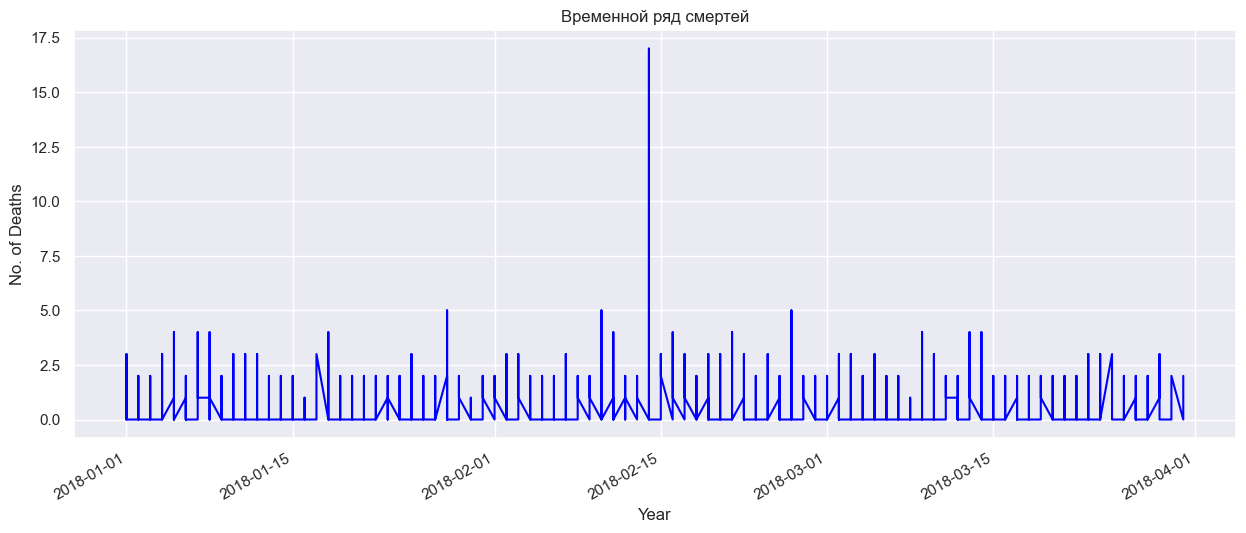

In [272]:
df_ts['n_killed'].plot(figsize=(15,6), color="blue")
plt.xlabel('Year')
plt.ylabel('No. of Deaths')
plt.title("Временной ряд смертей")
plt.show()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/denisserbin/PycharmProjects/nmla_lab1_serbin/venv/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/denisserbin/PycharmProjects/nmla_lab1_serbin/venv/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/denisserbin/PycharmProjects/nmla_lab1_serbin/venv/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -10.2958
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       40964.7   0.000203585       113.512       0.198      0.9689      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       40965.2   8.02531e-06       185.222      0.4201      0.4201      248   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     246       40965.3   9.45519e-06        215.07   3.515e-08       0.001      351  LS failed, Hessian reset 
     299       40965.4   3.35555e-05       90.2301           1           1      416   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     371       40965.4   4.62654e-06       74.5086    2.33e-08       0.001      556  LS failed, Hessian reset 
     399       40965.5   7.66748e-06       59.3653           1           1      597   
    Iter      log pro

/Users/denisserbin/PycharmProjects/nmla_lab1_serbin/venv/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



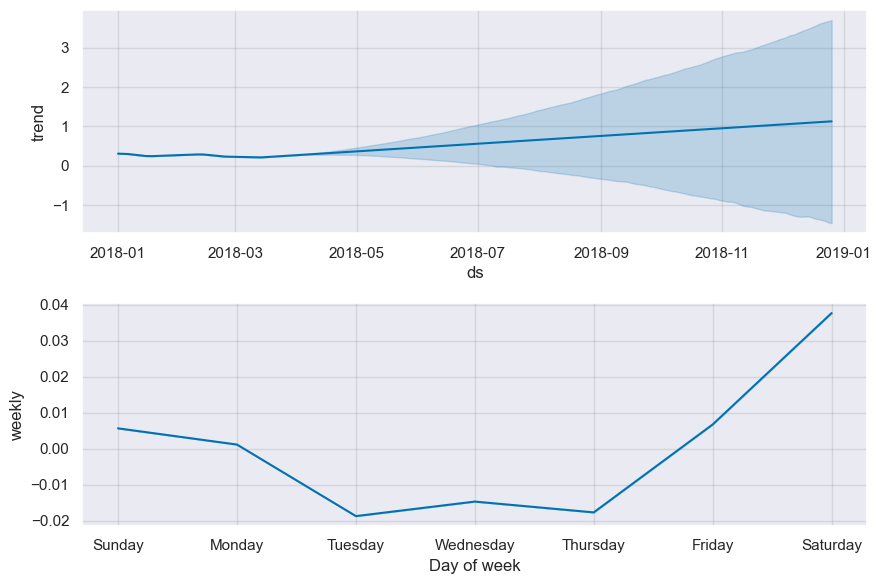

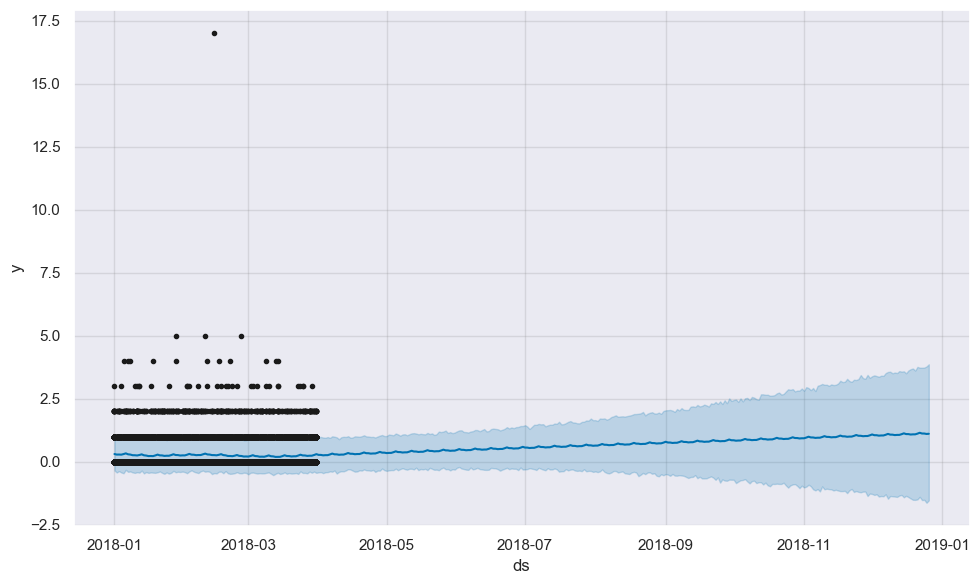

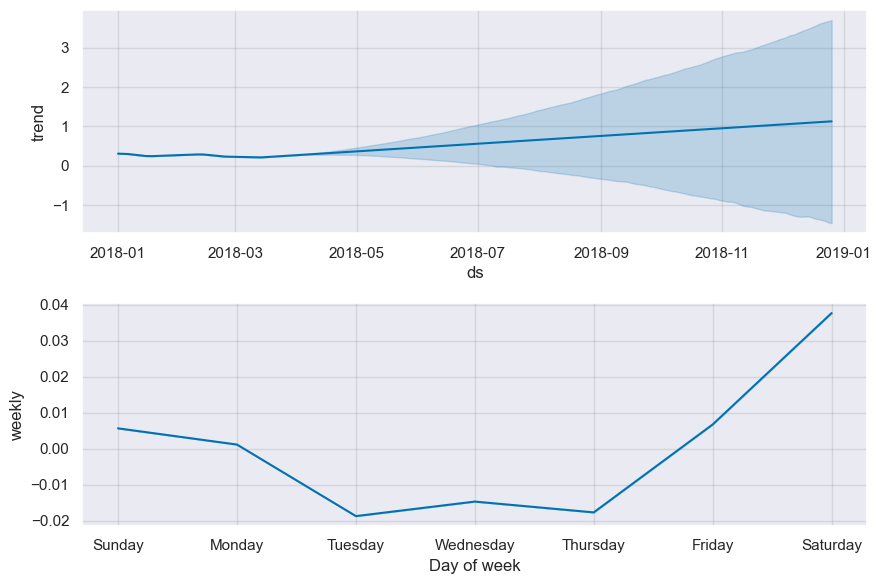

In [273]:
from fbprophet import Prophet
sns.set(font_scale=1)
df_date_index = df_18[['date','n_killed']]
df_date_index = df_date_index.set_index('date')
df_prophet = df_date_index.copy()
df_prophet.reset_index(drop=False,inplace=True)
df_prophet.columns = ['ds','y']

m = Prophet()
m.fit(df_prophet)
future = m.make_future_dataframe(periods=270,freq='D')
forecast = m.predict(future)
fig = m.plot(forecast)
m.plot_components(forecast)

In [274]:
gv_df_clean = gv_df_clean.dropna(subset=['state', 'participant_age', 'participant_gender',
                                         'date', 'state_house_district', 'state_senate_district',
                                         'congressional_district', 'latitude', 'longitude', ])
gv_df_clean

,incident_id,date,state,city_or_county,address,n_killed,n_injured,congressional_district,gun_stolen,incident_characteristics,latitude,location_description,longitude,n_guns_involved,participant_age,participant_gender,participant_relationship,participant_status,state_house_district,state_senate_district
1,460726,2013-01-01,California,Hawthorne,13500 block of Cerise Avenue,1,3,43.0,NaN,"Shot - Wounded/Injured||Shot - Dead (murder, a...",33.9090,NaN,-118.3330,NaN,0::20,0::Male,NaN,0::Killed||1::Injured||2::Injured||3::Injured,62.0,35.0
2,478855,2013-01-01,Ohio,Lorain,1776 East 28th Street,1,3,9.0,0::Unknown||1::Unknown,"Shot - Wounded/Injured||Shot - Dead (murder, a...",41.4455,Cotton Club,-82.1377,2.0,0::25||1::31||2::33||3::34||4::33,0::Male||1::Male||2::Male||3::Male||4::Male,NaN,"0::Injured, Unharmed, Arrested||1::Unharmed, A...",56.0,13.0
3,478925,2013-01-05,Colorado,Aurora,16000 block of East Ithaca Place,4,0,6.0,NaN,"Shot - Dead (murder, accidental, suicide)||Off...",39.6518,NaN,-104.8020,NaN,0::29||1::33||2::56||3::33,0::Female||1::Male||2::Male||3::Male,NaN,0::Killed||1::Killed||2::Killed||3::Killed,40.0,28.0
4,478959,2013-01-07,North Carolina,Greensboro,307 Mourning Dove Terrace,2,2,6.0,0::Unknown||1::Unknown,"Shot - Wounded/Injured||Shot - Dead (murder, a...",36.1140,NaN,-79.9569,2.0,0::18||1::46||2::14||3::47,0::Female||1::Male||2::Male||3::Female,3::Family,0::Injured||1::Injured||2::Killed||3::Killed,62.0,27.0
5,478948,2013-01-07,Oklahoma,Tulsa,6000 block of South Owasso,4,0,1.0,NaN,"Shot - Dead (murder, accidental, suicide)||Hom...",36.2405,Fairmont Terrace,-95.9768,NaN,0::23||1::23||2::33||3::55,0::Female||1::Female||2::Female||3::Female||4:...,NaN,0::Killed||1::Killed||2::Killed||3::Killed||4:...,72.0,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239671,1082061,2018-03-31,Washington,Spokane (Spokane Valley),12600 block of N Willow Crest Ln,0,0,5.0,0::Unknown,Non-Shooting Incident||Possession (gun(s) foun...,47.6638,NaN,-117.2350,1.0,0::48,0::Male,NaN,"0::Unharmed, Arrested",4.0,4.0
239673,1083139,2018-03-31,Louisiana,Natchitoches,247 Keyser Ave,1,0,4.0,0::Unknown,"Shot - Dead (murder, accidental, suicide)||Ins...",31.7537,Shop Rite,-93.0836,1.0,1::21,0::Male||1::Male,NaN,"0::Killed||1::Unharmed, Arrested",23.0,31.0
239674,1083151,2018-03-31,Louisiana,Gretna,1300 block of Cook Street,0,1,2.0,0::Unknown,Shot - Wounded/Injured,29.9239,NaN,-90.0442,1.0,0::21,0::Male,NaN,0::Injured,85.0,7.0
239675,1082514,2018-03-31,Texas,Houston,12630 Ashford Point Dr,1,0,9.0,0::Unknown,"Shot - Dead (murder, accidental, suicide)",29.7201,Vanderbilt Court apartments,-95.6110,1.0,0::42,0::Male,NaN,0::Killed,149.0,17.0


In [275]:
gv_df_info = gv_df_clean[['state', 'city_or_county', 'participant_age', 'participant_gender',
                                         'date', 'latitude', 'longitude', 'n_killed', 'n_injured' ]]

gv_df_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 121916 entries, 1 to 239676
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   state               121916 non-null  object        
 1   city_or_county      121916 non-null  object        
 2   participant_age     121916 non-null  object        
 3   participant_gender  121916 non-null  object        
 4   date                121916 non-null  datetime64[ns]
 5   latitude            121916 non-null  float64       
 6   longitude           121916 non-null  float64       
 7   n_killed            121916 non-null  int64         
 8   n_injured           121916 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 9.3+ MB


In [276]:
gv_df_clean = gv_df_clean.drop(columns=['gun_stolen', 'address', 'incident_characteristics', 'location_description'])
gv_df_clean


,incident_id,date,state,city_or_county,n_killed,n_injured,congressional_district,latitude,longitude,n_guns_involved,participant_age,participant_gender,participant_relationship,participant_status,state_house_district,state_senate_district
1,460726,2013-01-01,California,Hawthorne,1,3,43.0,33.9090,-118.3330,NaN,0::20,0::Male,NaN,0::Killed||1::Injured||2::Injured||3::Injured,62.0,35.0
2,478855,2013-01-01,Ohio,Lorain,1,3,9.0,41.4455,-82.1377,2.0,0::25||1::31||2::33||3::34||4::33,0::Male||1::Male||2::Male||3::Male||4::Male,NaN,"0::Injured, Unharmed, Arrested||1::Unharmed, A...",56.0,13.0
3,478925,2013-01-05,Colorado,Aurora,4,0,6.0,39.6518,-104.8020,NaN,0::29||1::33||2::56||3::33,0::Female||1::Male||2::Male||3::Male,NaN,0::Killed||1::Killed||2::Killed||3::Killed,40.0,28.0
4,478959,2013-01-07,North Carolina,Greensboro,2,2,6.0,36.1140,-79.9569,2.0,0::18||1::46||2::14||3::47,0::Female||1::Male||2::Male||3::Female,3::Family,0::Injured||1::Injured||2::Killed||3::Killed,62.0,27.0
5,478948,2013-01-07,Oklahoma,Tulsa,4,0,1.0,36.2405,-95.9768,NaN,0::23||1::23||2::33||3::55,0::Female||1::Female||2::Female||3::Female||4:...,NaN,0::Killed||1::Killed||2::Killed||3::Killed||4:...,72.0,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239671,1082061,2018-03-31,Washington,Spokane (Spokane Valley),0,0,5.0,47.6638,-117.2350,1.0,0::48,0::Male,NaN,"0::Unharmed, Arrested",4.0,4.0
239673,1083139,2018-03-31,Louisiana,Natchitoches,1,0,4.0,31.7537,-93.0836,1.0,1::21,0::Male||1::Male,NaN,"0::Killed||1::Unharmed, Arrested",23.0,31.0
239674,1083151,2018-03-31,Louisiana,Gretna,0,1,2.0,29.9239,-90.0442,1.0,0::21,0::Male,NaN,0::Injured,85.0,7.0
239675,1082514,2018-03-31,Texas,Houston,1,0,9.0,29.7201,-95.6110,1.0,0::42,0::Male,NaN,0::Killed,149.0,17.0


In [277]:
gv_df_clean = gv_df_clean.drop(columns=['n_guns_involved', 'participant_relationship', ])
gv_df_clean

,incident_id,date,state,city_or_county,n_killed,n_injured,congressional_district,latitude,longitude,participant_age,participant_gender,participant_status,state_house_district,state_senate_district
1,460726,2013-01-01,California,Hawthorne,1,3,43.0,33.9090,-118.3330,0::20,0::Male,0::Killed||1::Injured||2::Injured||3::Injured,62.0,35.0
2,478855,2013-01-01,Ohio,Lorain,1,3,9.0,41.4455,-82.1377,0::25||1::31||2::33||3::34||4::33,0::Male||1::Male||2::Male||3::Male||4::Male,"0::Injured, Unharmed, Arrested||1::Unharmed, A...",56.0,13.0
3,478925,2013-01-05,Colorado,Aurora,4,0,6.0,39.6518,-104.8020,0::29||1::33||2::56||3::33,0::Female||1::Male||2::Male||3::Male,0::Killed||1::Killed||2::Killed||3::Killed,40.0,28.0
4,478959,2013-01-07,North Carolina,Greensboro,2,2,6.0,36.1140,-79.9569,0::18||1::46||2::14||3::47,0::Female||1::Male||2::Male||3::Female,0::Injured||1::Injured||2::Killed||3::Killed,62.0,27.0
5,478948,2013-01-07,Oklahoma,Tulsa,4,0,1.0,36.2405,-95.9768,0::23||1::23||2::33||3::55,0::Female||1::Female||2::Female||3::Female||4:...,0::Killed||1::Killed||2::Killed||3::Killed||4:...,72.0,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239671,1082061,2018-03-31,Washington,Spokane (Spokane Valley),0,0,5.0,47.6638,-117.2350,0::48,0::Male,"0::Unharmed, Arrested",4.0,4.0
239673,1083139,2018-03-31,Louisiana,Natchitoches,1,0,4.0,31.7537,-93.0836,1::21,0::Male||1::Male,"0::Killed||1::Unharmed, Arrested",23.0,31.0
239674,1083151,2018-03-31,Louisiana,Gretna,0,1,2.0,29.9239,-90.0442,0::21,0::Male,0::Injured,85.0,7.0
239675,1082514,2018-03-31,Texas,Houston,1,0,9.0,29.7201,-95.6110,0::42,0::Male,0::Killed,149.0,17.0


In [278]:
# 6

In [279]:
gv_df_clean['is_killed'] = gv_df_clean.apply(lambda row: True if row['n_killed'] > 0 else False, axis=1)
gv_df_clean

,incident_id,date,state,city_or_county,n_killed,n_injured,congressional_district,latitude,longitude,participant_age,participant_gender,participant_status,state_house_district,state_senate_district,is_killed
1,460726,2013-01-01,California,Hawthorne,1,3,43.0,33.9090,-118.3330,0::20,0::Male,0::Killed||1::Injured||2::Injured||3::Injured,62.0,35.0,True
2,478855,2013-01-01,Ohio,Lorain,1,3,9.0,41.4455,-82.1377,0::25||1::31||2::33||3::34||4::33,0::Male||1::Male||2::Male||3::Male||4::Male,"0::Injured, Unharmed, Arrested||1::Unharmed, A...",56.0,13.0,True
3,478925,2013-01-05,Colorado,Aurora,4,0,6.0,39.6518,-104.8020,0::29||1::33||2::56||3::33,0::Female||1::Male||2::Male||3::Male,0::Killed||1::Killed||2::Killed||3::Killed,40.0,28.0,True
4,478959,2013-01-07,North Carolina,Greensboro,2,2,6.0,36.1140,-79.9569,0::18||1::46||2::14||3::47,0::Female||1::Male||2::Male||3::Female,0::Injured||1::Injured||2::Killed||3::Killed,62.0,27.0,True
5,478948,2013-01-07,Oklahoma,Tulsa,4,0,1.0,36.2405,-95.9768,0::23||1::23||2::33||3::55,0::Female||1::Female||2::Female||3::Female||4:...,0::Killed||1::Killed||2::Killed||3::Killed||4:...,72.0,11.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239671,1082061,2018-03-31,Washington,Spokane (Spokane Valley),0,0,5.0,47.6638,-117.2350,0::48,0::Male,"0::Unharmed, Arrested",4.0,4.0,False
239673,1083139,2018-03-31,Louisiana,Natchitoches,1,0,4.0,31.7537,-93.0836,1::21,0::Male||1::Male,"0::Killed||1::Unharmed, Arrested",23.0,31.0,True
239674,1083151,2018-03-31,Louisiana,Gretna,0,1,2.0,29.9239,-90.0442,0::21,0::Male,0::Injured,85.0,7.0,False
239675,1082514,2018-03-31,Texas,Houston,1,0,9.0,29.7201,-95.6110,0::42,0::Male,0::Killed,149.0,17.0,True


In [280]:
gv_df_clean['is_injured'] = gv_df_clean.apply(lambda row: True if row['n_injured'] > 0 else False, axis=1)
gv_df_clean

,incident_id,date,state,city_or_county,n_killed,n_injured,congressional_district,latitude,longitude,participant_age,participant_gender,participant_status,state_house_district,state_senate_district,is_killed,is_injured
1,460726,2013-01-01,California,Hawthorne,1,3,43.0,33.9090,-118.3330,0::20,0::Male,0::Killed||1::Injured||2::Injured||3::Injured,62.0,35.0,True,True
2,478855,2013-01-01,Ohio,Lorain,1,3,9.0,41.4455,-82.1377,0::25||1::31||2::33||3::34||4::33,0::Male||1::Male||2::Male||3::Male||4::Male,"0::Injured, Unharmed, Arrested||1::Unharmed, A...",56.0,13.0,True,True
3,478925,2013-01-05,Colorado,Aurora,4,0,6.0,39.6518,-104.8020,0::29||1::33||2::56||3::33,0::Female||1::Male||2::Male||3::Male,0::Killed||1::Killed||2::Killed||3::Killed,40.0,28.0,True,False
4,478959,2013-01-07,North Carolina,Greensboro,2,2,6.0,36.1140,-79.9569,0::18||1::46||2::14||3::47,0::Female||1::Male||2::Male||3::Female,0::Injured||1::Injured||2::Killed||3::Killed,62.0,27.0,True,True
5,478948,2013-01-07,Oklahoma,Tulsa,4,0,1.0,36.2405,-95.9768,0::23||1::23||2::33||3::55,0::Female||1::Female||2::Female||3::Female||4:...,0::Killed||1::Killed||2::Killed||3::Killed||4:...,72.0,11.0,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239671,1082061,2018-03-31,Washington,Spokane (Spokane Valley),0,0,5.0,47.6638,-117.2350,0::48,0::Male,"0::Unharmed, Arrested",4.0,4.0,False,False
239673,1083139,2018-03-31,Louisiana,Natchitoches,1,0,4.0,31.7537,-93.0836,1::21,0::Male||1::Male,"0::Killed||1::Unharmed, Arrested",23.0,31.0,True,False
239674,1083151,2018-03-31,Louisiana,Gretna,0,1,2.0,29.9239,-90.0442,0::21,0::Male,0::Injured,85.0,7.0,False,True
239675,1082514,2018-03-31,Texas,Houston,1,0,9.0,29.7201,-95.6110,0::42,0::Male,0::Killed,149.0,17.0,True,False


In [281]:
gv_df_clean['year'] = gv_df_clean.apply(lambda row: row['date'].year, axis=1)
gv_df_clean

,incident_id,date,state,city_or_county,n_killed,n_injured,congressional_district,latitude,longitude,participant_age,participant_gender,participant_status,state_house_district,state_senate_district,is_killed,is_injured,year
1,460726,2013-01-01,California,Hawthorne,1,3,43.0,33.9090,-118.3330,0::20,0::Male,0::Killed||1::Injured||2::Injured||3::Injured,62.0,35.0,True,True,2013
2,478855,2013-01-01,Ohio,Lorain,1,3,9.0,41.4455,-82.1377,0::25||1::31||2::33||3::34||4::33,0::Male||1::Male||2::Male||3::Male||4::Male,"0::Injured, Unharmed, Arrested||1::Unharmed, A...",56.0,13.0,True,True,2013
3,478925,2013-01-05,Colorado,Aurora,4,0,6.0,39.6518,-104.8020,0::29||1::33||2::56||3::33,0::Female||1::Male||2::Male||3::Male,0::Killed||1::Killed||2::Killed||3::Killed,40.0,28.0,True,False,2013
4,478959,2013-01-07,North Carolina,Greensboro,2,2,6.0,36.1140,-79.9569,0::18||1::46||2::14||3::47,0::Female||1::Male||2::Male||3::Female,0::Injured||1::Injured||2::Killed||3::Killed,62.0,27.0,True,True,2013
5,478948,2013-01-07,Oklahoma,Tulsa,4,0,1.0,36.2405,-95.9768,0::23||1::23||2::33||3::55,0::Female||1::Female||2::Female||3::Female||4:...,0::Killed||1::Killed||2::Killed||3::Killed||4:...,72.0,11.0,True,False,2013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239671,1082061,2018-03-31,Washington,Spokane (Spokane Valley),0,0,5.0,47.6638,-117.2350,0::48,0::Male,"0::Unharmed, Arrested",4.0,4.0,False,False,2018
239673,1083139,2018-03-31,Louisiana,Natchitoches,1,0,4.0,31.7537,-93.0836,1::21,0::Male||1::Male,"0::Killed||1::Unharmed, Arrested",23.0,31.0,True,False,2018
239674,1083151,2018-03-31,Louisiana,Gretna,0,1,2.0,29.9239,-90.0442,0::21,0::Male,0::Injured,85.0,7.0,False,True,2018
239675,1082514,2018-03-31,Texas,Houston,1,0,9.0,29.7201,-95.6110,0::42,0::Male,0::Killed,149.0,17.0,True,False,2018


In [282]:
gv_df_clean['month'] = gv_df_clean.apply(lambda row: row['date'].month, axis=1)
gv_df_clean

,incident_id,date,state,city_or_county,n_killed,n_injured,congressional_district,latitude,longitude,participant_age,participant_gender,participant_status,state_house_district,state_senate_district,is_killed,is_injured,year,month
1,460726,2013-01-01,California,Hawthorne,1,3,43.0,33.9090,-118.3330,0::20,0::Male,0::Killed||1::Injured||2::Injured||3::Injured,62.0,35.0,True,True,2013,1
2,478855,2013-01-01,Ohio,Lorain,1,3,9.0,41.4455,-82.1377,0::25||1::31||2::33||3::34||4::33,0::Male||1::Male||2::Male||3::Male||4::Male,"0::Injured, Unharmed, Arrested||1::Unharmed, A...",56.0,13.0,True,True,2013,1
3,478925,2013-01-05,Colorado,Aurora,4,0,6.0,39.6518,-104.8020,0::29||1::33||2::56||3::33,0::Female||1::Male||2::Male||3::Male,0::Killed||1::Killed||2::Killed||3::Killed,40.0,28.0,True,False,2013,1
4,478959,2013-01-07,North Carolina,Greensboro,2,2,6.0,36.1140,-79.9569,0::18||1::46||2::14||3::47,0::Female||1::Male||2::Male||3::Female,0::Injured||1::Injured||2::Killed||3::Killed,62.0,27.0,True,True,2013,1
5,478948,2013-01-07,Oklahoma,Tulsa,4,0,1.0,36.2405,-95.9768,0::23||1::23||2::33||3::55,0::Female||1::Female||2::Female||3::Female||4:...,0::Killed||1::Killed||2::Killed||3::Killed||4:...,72.0,11.0,True,False,2013,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239671,1082061,2018-03-31,Washington,Spokane (Spokane Valley),0,0,5.0,47.6638,-117.2350,0::48,0::Male,"0::Unharmed, Arrested",4.0,4.0,False,False,2018,3
239673,1083139,2018-03-31,Louisiana,Natchitoches,1,0,4.0,31.7537,-93.0836,1::21,0::Male||1::Male,"0::Killed||1::Unharmed, Arrested",23.0,31.0,True,False,2018,3
239674,1083151,2018-03-31,Louisiana,Gretna,0,1,2.0,29.9239,-90.0442,0::21,0::Male,0::Injured,85.0,7.0,False,True,2018,3
239675,1082514,2018-03-31,Texas,Houston,1,0,9.0,29.7201,-95.6110,0::42,0::Male,0::Killed,149.0,17.0,True,False,2018,3


In [283]:
gv_df_clean['day'] = gv_df_clean.apply(lambda row: row['date'].day, axis=1)
gv_df_clean

,incident_id,date,state,city_or_county,n_killed,n_injured,congressional_district,latitude,longitude,participant_age,participant_gender,participant_status,state_house_district,state_senate_district,is_killed,is_injured,year,month,day
1,460726,2013-01-01,California,Hawthorne,1,3,43.0,33.9090,-118.3330,0::20,0::Male,0::Killed||1::Injured||2::Injured||3::Injured,62.0,35.0,True,True,2013,1,1
2,478855,2013-01-01,Ohio,Lorain,1,3,9.0,41.4455,-82.1377,0::25||1::31||2::33||3::34||4::33,0::Male||1::Male||2::Male||3::Male||4::Male,"0::Injured, Unharmed, Arrested||1::Unharmed, A...",56.0,13.0,True,True,2013,1,1
3,478925,2013-01-05,Colorado,Aurora,4,0,6.0,39.6518,-104.8020,0::29||1::33||2::56||3::33,0::Female||1::Male||2::Male||3::Male,0::Killed||1::Killed||2::Killed||3::Killed,40.0,28.0,True,False,2013,1,5
4,478959,2013-01-07,North Carolina,Greensboro,2,2,6.0,36.1140,-79.9569,0::18||1::46||2::14||3::47,0::Female||1::Male||2::Male||3::Female,0::Injured||1::Injured||2::Killed||3::Killed,62.0,27.0,True,True,2013,1,7
5,478948,2013-01-07,Oklahoma,Tulsa,4,0,1.0,36.2405,-95.9768,0::23||1::23||2::33||3::55,0::Female||1::Female||2::Female||3::Female||4:...,0::Killed||1::Killed||2::Killed||3::Killed||4:...,72.0,11.0,True,False,2013,1,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239671,1082061,2018-03-31,Washington,Spokane (Spokane Valley),0,0,5.0,47.6638,-117.2350,0::48,0::Male,"0::Unharmed, Arrested",4.0,4.0,False,False,2018,3,31
239673,1083139,2018-03-31,Louisiana,Natchitoches,1,0,4.0,31.7537,-93.0836,1::21,0::Male||1::Male,"0::Killed||1::Unharmed, Arrested",23.0,31.0,True,False,2018,3,31
239674,1083151,2018-03-31,Louisiana,Gretna,0,1,2.0,29.9239,-90.0442,0::21,0::Male,0::Injured,85.0,7.0,False,True,2018,3,31
239675,1082514,2018-03-31,Texas,Houston,1,0,9.0,29.7201,-95.6110,0::42,0::Male,0::Killed,149.0,17.0,True,False,2018,3,31


In [284]:
city_codes = {}


def add_city_code(city_str):
    if city_codes.get(city_str) is not None:
        return city_codes[city_str]
    else:
        city_codes[city_str] = len(city_codes)
        return city_codes[city_str]


gv_df_clean['city_code'] = gv_df_clean.apply(lambda row: add_city_code(row['city_or_county']), axis=1)
gv_df_clean

,incident_id,date,state,city_or_county,n_killed,n_injured,congressional_district,latitude,longitude,participant_age,participant_gender,participant_status,state_house_district,state_senate_district,is_killed,is_injured,year,month,day,city_code
1,460726,2013-01-01,California,Hawthorne,1,3,43.0,33.9090,-118.3330,0::20,0::Male,0::Killed||1::Injured||2::Injured||3::Injured,62.0,35.0,True,True,2013,1,1,0
2,478855,2013-01-01,Ohio,Lorain,1,3,9.0,41.4455,-82.1377,0::25||1::31||2::33||3::34||4::33,0::Male||1::Male||2::Male||3::Male||4::Male,"0::Injured, Unharmed, Arrested||1::Unharmed, A...",56.0,13.0,True,True,2013,1,1,1
3,478925,2013-01-05,Colorado,Aurora,4,0,6.0,39.6518,-104.8020,0::29||1::33||2::56||3::33,0::Female||1::Male||2::Male||3::Male,0::Killed||1::Killed||2::Killed||3::Killed,40.0,28.0,True,False,2013,1,5,2
4,478959,2013-01-07,North Carolina,Greensboro,2,2,6.0,36.1140,-79.9569,0::18||1::46||2::14||3::47,0::Female||1::Male||2::Male||3::Female,0::Injured||1::Injured||2::Killed||3::Killed,62.0,27.0,True,True,2013,1,7,3
5,478948,2013-01-07,Oklahoma,Tulsa,4,0,1.0,36.2405,-95.9768,0::23||1::23||2::33||3::55,0::Female||1::Female||2::Female||3::Female||4:...,0::Killed||1::Killed||2::Killed||3::Killed||4:...,72.0,11.0,True,False,2013,1,7,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239671,1082061,2018-03-31,Washington,Spokane (Spokane Valley),0,0,5.0,47.6638,-117.2350,0::48,0::Male,"0::Unharmed, Arrested",4.0,4.0,False,False,2018,3,31,3755
239673,1083139,2018-03-31,Louisiana,Natchitoches,1,0,4.0,31.7537,-93.0836,1::21,0::Male||1::Male,"0::Killed||1::Unharmed, Arrested",23.0,31.0,True,False,2018,3,31,392
239674,1083151,2018-03-31,Louisiana,Gretna,0,1,2.0,29.9239,-90.0442,0::21,0::Male,0::Injured,85.0,7.0,False,True,2018,3,31,2009
239675,1082514,2018-03-31,Texas,Houston,1,0,9.0,29.7201,-95.6110,0::42,0::Male,0::Killed,149.0,17.0,True,False,2018,3,31,61


In [285]:
def parse_age(participant_age_str):
    ages_str = participant_age_str.replace('||', '|').split('|')
    ages = []
    for age_str in ages_str:
        right = age_str.replace('::', ':').split(':')
        ages.append(int(right[1]))
    sum = 0
    for i in range(0, len(ages)):
        sum += ages[i]
    return sum / len(ages)


def parse_gender(part_gender_str):
    genders_str = part_gender_str.replace('||', '|').split('|')
    genders = []
    for gender_str in genders_str:
        right = gender_str.replace('::', ':').split(':')
        genders.append(right[1])

    n_male = 0
    n_female = 0
    for i in range(0, len(genders)):
        if genders[i] == 'Male':
            n_male += 1
        elif genders[i] == 'Female':
            n_female += 1
    return 'Male' if n_male > n_female else 'Female'


gv_df_clean['average_age'] = gv_df_clean.apply(lambda row: parse_age(row['participant_age']), axis=1)
gv_df_clean['average_gender'] = gv_df_clean.apply(lambda row: parse_gender(row['participant_gender']), axis=1)

gv_df_clean

,incident_id,date,state,city_or_county,n_killed,n_injured,congressional_district,latitude,longitude,participant_age,participant_gender,participant_status,state_house_district,state_senate_district,is_killed,is_injured,year,month,day,city_code,average_age,average_gender
1,460726,2013-01-01,California,Hawthorne,1,3,43.0,33.9090,-118.3330,0::20,0::Male,0::Killed||1::Injured||2::Injured||3::Injured,62.0,35.0,True,True,2013,1,1,0,20.00,Male
2,478855,2013-01-01,Ohio,Lorain,1,3,9.0,41.4455,-82.1377,0::25||1::31||2::33||3::34||4::33,0::Male||1::Male||2::Male||3::Male||4::Male,"0::Injured, Unharmed, Arrested||1::Unharmed, A...",56.0,13.0,True,True,2013,1,1,1,31.20,Male
3,478925,2013-01-05,Colorado,Aurora,4,0,6.0,39.6518,-104.8020,0::29||1::33||2::56||3::33,0::Female||1::Male||2::Male||3::Male,0::Killed||1::Killed||2::Killed||3::Killed,40.0,28.0,True,False,2013,1,5,2,37.75,Male
4,478959,2013-01-07,North Carolina,Greensboro,2,2,6.0,36.1140,-79.9569,0::18||1::46||2::14||3::47,0::Female||1::Male||2::Male||3::Female,0::Injured||1::Injured||2::Killed||3::Killed,62.0,27.0,True,True,2013,1,7,3,31.25,Female
5,478948,2013-01-07,Oklahoma,Tulsa,4,0,1.0,36.2405,-95.9768,0::23||1::23||2::33||3::55,0::Female||1::Female||2::Female||3::Female||4:...,0::Killed||1::Killed||2::Killed||3::Killed||4:...,72.0,11.0,True,False,2013,1,7,4,33.50,Female
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239671,1082061,2018-03-31,Washington,Spokane (Spokane Valley),0,0,5.0,47.6638,-117.2350,0::48,0::Male,"0::Unharmed, Arrested",4.0,4.0,False,False,2018,3,31,3755,48.00,Male
239673,1083139,2018-03-31,Louisiana,Natchitoches,1,0,4.0,31.7537,-93.0836,1::21,0::Male||1::Male,"0::Killed||1::Unharmed, Arrested",23.0,31.0,True,False,2018,3,31,392,21.00,Male
239674,1083151,2018-03-31,Louisiana,Gretna,0,1,2.0,29.9239,-90.0442,0::21,0::Male,0::Injured,85.0,7.0,False,True,2018,3,31,2009,21.00,Male
239675,1082514,2018-03-31,Texas,Houston,1,0,9.0,29.7201,-95.6110,0::42,0::Male,0::Killed,149.0,17.0,True,False,2018,3,31,61,42.00,Male


In [286]:
gv_df_clean = gv_df_clean.drop(
    columns=['participant_age', 'participant_gender', 'participant_status', 'n_killed', 'n_injured'])
gv_df_clean

,incident_id,date,state,city_or_county,congressional_district,latitude,longitude,state_house_district,state_senate_district,is_killed,is_injured,year,month,day,city_code,average_age,average_gender
1,460726,2013-01-01,California,Hawthorne,43.0,33.9090,-118.3330,62.0,35.0,True,True,2013,1,1,0,20.00,Male
2,478855,2013-01-01,Ohio,Lorain,9.0,41.4455,-82.1377,56.0,13.0,True,True,2013,1,1,1,31.20,Male
3,478925,2013-01-05,Colorado,Aurora,6.0,39.6518,-104.8020,40.0,28.0,True,False,2013,1,5,2,37.75,Male
4,478959,2013-01-07,North Carolina,Greensboro,6.0,36.1140,-79.9569,62.0,27.0,True,True,2013,1,7,3,31.25,Female
5,478948,2013-01-07,Oklahoma,Tulsa,1.0,36.2405,-95.9768,72.0,11.0,True,False,2013,1,7,4,33.50,Female
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239671,1082061,2018-03-31,Washington,Spokane (Spokane Valley),5.0,47.6638,-117.2350,4.0,4.0,False,False,2018,3,31,3755,48.00,Male
239673,1083139,2018-03-31,Louisiana,Natchitoches,4.0,31.7537,-93.0836,23.0,31.0,True,False,2018,3,31,392,21.00,Male
239674,1083151,2018-03-31,Louisiana,Gretna,2.0,29.9239,-90.0442,85.0,7.0,False,True,2018,3,31,2009,21.00,Male
239675,1082514,2018-03-31,Texas,Houston,9.0,29.7201,-95.6110,149.0,17.0,True,False,2018,3,31,61,42.00,Male


In [287]:
state_names = ["Alabama", "Alaska", "Arizona", "Arkansas", "California", "Colorado", "Connecticut",
               "District of Columbia", "Delaware", "Florida", "Georgia", "Hawaii", "Idaho", "Illinois", "Indiana",
               "Iowa", "Kansas", "Kentucky", "Louisiana", "Maine", "Maryland", "Massachusetts", "Michigan", "Minnesota",
               "Mississippi", "Missouri", "Montana", "Nebraska", "Nevada", "New Hampshire", "New Jersey", "New Mexico",
               "New York", "North Carolina", "North Dakota", "Ohio", "Oklahoma", "Oregon", "Pennsylvania",
               "Rhode Island", "South Carolina", "South Dakota", "Tennessee", "Texas", "Utah", "Vermont", "Virginia",
               "Washington", "West Virginia", "Wisconsin", "Wyoming"]


def find_state_code(state):
    for i in range(0, len(state_names)):
        if state.upper().replace(' ', '') == state_names[i].upper().replace(' ', ''):
            return i


gv_df_clean['state_code'] = gv_df_clean.apply(lambda row: find_state_code(row['state']), axis=1)
gv_df_clean['gender_bool'] = gv_df_clean.apply(lambda row: 1 if row['average_gender'] == 'Male' else 0, axis=1)
gv_df_clean['is_injured_or_killed'] = gv_df_clean.apply(lambda row: 1 if row['is_killed'] or row['is_injured'] else 0,
                                                        axis=1)

gv_df_clean[gv_df_clean.loc[:, 'state'] == 'District of Columbia']

,incident_id,date,state,city_or_county,congressional_district,latitude,longitude,state_house_district,state_senate_district,is_killed,is_injured,year,month,day,city_code,average_age,average_gender,state_code,gender_bool,is_injured_or_killed
148036,664179,2016-09-25,District of Columbia,Washington,8.0,38.9931,-77.0771,18.0,18.0,False,False,2016,9,25,2374,65.0,Male,7,1,0
163375,734625,2016-12-26,District of Columbia,Washington,8.0,38.9764,-77.0156,20.0,20.0,True,False,2016,12,26,2374,32.5,Male,7,1,1
180897,815557,2017-04-09,District of Columbia,Washington,4.0,38.8356,-76.9828,26.0,26.0,True,False,2017,4,9,2374,25.0,Male,7,1,1


In [288]:
gv_df_clean.is_injured_or_killed[gv_df_clean['is_injured_or_killed'] == 0]

289       0
295       0
312       0
317       0
319       0
         ..
239573    0
239596    0
239639    0
239657    0
239671    0
Name: is_injured_or_killed, Length: 36928, dtype: int64

In [289]:
gv_ones = gv_df_clean[gv_df_clean['is_injured_or_killed'] != 0].sample(frac=0.5, random_state=12345)
gv_ones


,incident_id,date,state,city_or_county,congressional_district,latitude,longitude,state_house_district,state_senate_district,is_killed,is_injured,year,month,day,city_code,average_age,average_gender,state_code,gender_bool,is_injured_or_killed
129490,572483,2016-06-05,New York,Brooklyn,9.0,40.6704,-73.9229,55.0,20.0,True,False,2016,6,5,30,25.0,Male,32,1,1
13262,125893,2014-04-15,New Jersey,Paterson,9.0,40.9235,-74.1454,35.0,35.0,True,False,2014,4,15,451,24.0,Male,30,1,1
51044,267801,2014-12-23,West Virginia,Charleston,2.0,38.3647,-81.6548,37.0,8.0,False,True,2014,12,23,207,43.5,Female,48,0,1
94224,430016,2015-10-13,Virginia,Alexandria,8.0,38.7906,-77.1262,43.0,39.0,False,True,2015,10,13,435,18.0,Male,46,1,1
41888,211706,2014-10-15,New Mexico,Albuquerque,1.0,35.0728,-106.6110,18.0,16.0,True,False,2014,10,15,5,91.5,Female,31,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97045,440926,2015-11-01,Connecticut,New Haven,3.0,41.3320,-72.9327,94.0,10.0,False,True,2015,11,1,116,13.0,Male,6,1,1
182252,1021058,2017-04-16,Pennsylvania,Stroudsburg,10.0,40.9882,-75.1976,115.0,40.0,False,True,2017,4,16,8360,22.5,Male,38,1,1
99734,450520,2015-11-19,Virginia,Bohannon,1.0,37.3850,-76.3515,98.0,6.0,True,False,2015,11,19,6207,15.0,Male,46,1,1
94985,433730,2015-10-18,Texas,Houston,18.0,29.7826,-95.3382,142.0,13.0,True,False,2015,10,18,61,51.0,Male,43,1,1


In [290]:
gv_df_clean = pd.concat([gv_ones] + [gv_df_clean[gv_df_clean['is_injured_or_killed'] == 0]])


In [291]:
filter_age = gv_df_clean['average_age'] < 80
filter_age_2 = gv_df_clean['average_age'] > 13
gv_df_clean = gv_df_clean[filter_age & filter_age_2]
gv_df_clean

,incident_id,date,state,city_or_county,congressional_district,latitude,longitude,state_house_district,state_senate_district,is_killed,is_injured,year,month,day,city_code,average_age,average_gender,state_code,gender_bool,is_injured_or_killed
129490,572483,2016-06-05,New York,Brooklyn,9.0,40.6704,-73.9229,55.0,20.0,True,False,2016,6,5,30,25.0,Male,32,1,1
13262,125893,2014-04-15,New Jersey,Paterson,9.0,40.9235,-74.1454,35.0,35.0,True,False,2014,4,15,451,24.0,Male,30,1,1
51044,267801,2014-12-23,West Virginia,Charleston,2.0,38.3647,-81.6548,37.0,8.0,False,True,2014,12,23,207,43.5,Female,48,0,1
94224,430016,2015-10-13,Virginia,Alexandria,8.0,38.7906,-77.1262,43.0,39.0,False,True,2015,10,13,435,18.0,Male,46,1,1
51959,271694,2014-12-30,Wisconsin,Milwaukee,4.0,43.0843,-87.9655,18.0,6.0,True,False,2014,12,30,188,31.0,Male,49,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239573,1081994,2018-03-31,New York,Brooklyn,7.0,40.6438,-74.0185,51.0,20.0,False,False,2018,3,31,30,43.0,Male,32,1,0
239596,1082577,2018-03-31,Connecticut,Trumbull,4.0,41.2560,-73.2110,123.0,22.0,False,False,2018,3,31,5185,36.0,Male,6,1,0
239639,1082607,2018-03-31,California,Salinas,20.0,36.6191,-121.6360,30.0,12.0,False,False,2018,3,31,89,23.5,Male,4,1,0
239657,1082394,2018-03-31,California,Shafter,21.0,35.5019,-119.2830,32.0,14.0,False,False,2018,3,31,3440,55.0,Male,4,1,0


In [292]:
gv_df_clean.describe()

,incident_id,congressional_district,latitude,longitude,state_house_district,state_senate_district,year,month,day,city_code,average_age,state_code,gender_bool,is_injured_or_killed
count,7.794800e+04,77948.000000,77948.000000,77948.000000,77948.000000,77948.000000,77948.000000,77948.000000,77948.000000,77948.000000,77948.000000,77948.000000,77948.000000,77948.000000
mean,5.622122e+05,8.049700,37.497276,-89.464453,54.955470,20.447337,2015.721904,6.286216,15.713925,1284.351132,30.255549,23.138131,0.860612,0.532573
std,2.905326e+05,8.265773,4.953203,14.077632,43.504232,14.490067,1.212767,3.464784,8.834959,2006.007818,11.874977,14.388944,0.346353,0.498941
min,9.213100e+04,0.000000,19.112700,-159.412000,1.000000,1.000000,2013.000000,1.000000,1.000000,0.000000,13.166667,0.000000,0.000000,0.000000
25%,3.180462e+05,2.000000,33.918725,-92.890600,21.000000,8.000000,2015.000000,3.000000,8.000000,74.000000,21.333333,10.000000,1.000000,0.000000
50%,5.416085e+05,5.000000,38.635900,-86.767400,45.000000,18.000000,2016.000000,6.000000,16.000000,321.000000,27.000000,22.000000,1.000000,1.000000
75%,8.182140e+05,11.000000,41.591800,-80.336950,84.000000,30.000000,2017.000000,9.000000,23.000000,1562.000000,36.000000,35.000000,1.000000,1.000000
max,1.083435e+06,53.000000,61.229600,-67.271100,814.000000,63.000000,2018.000000,12.000000,31.000000,9546.000000,79.500000,50.000000,1.000000,1.000000


In [293]:
gv_df_clean[['year', 'month', 'day', 'city_code', 'average_age', 'state_code', 'gender_bool', 'latitude', 'longitude', 'is_injured_or_killed']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77948 entries, 129490 to 239671
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   year                  77948 non-null  int64  
 1   month                 77948 non-null  int64  
 2   day                   77948 non-null  int64  
 3   city_code             77948 non-null  int64  
 4   average_age           77948 non-null  float64
 5   state_code            77948 non-null  int64  
 6   gender_bool           77948 non-null  int64  
 7   latitude              77948 non-null  float64
 8   longitude             77948 non-null  float64
 9   is_injured_or_killed  77948 non-null  int64  
dtypes: float64(3), int64(7)
memory usage: 6.5 MB


In [294]:
gv_df_clean = shuffle(gv_df_clean)
gv_df_clean

,incident_id,date,state,city_or_county,congressional_district,latitude,longitude,state_house_district,state_senate_district,is_killed,is_injured,year,month,day,city_code,average_age,average_gender,state_code,gender_bool,is_injured_or_killed
10359,117779,2014-03-23,Florida,Pompano Beach,20.0,26.2665,-80.1174,92.0,31.0,False,False,2014,3,23,73,23.000000,Female,9,0,0
211187,945803,2017-09-30,Tennessee,Nashville,5.0,36.0786,-86.6433,52.0,19.0,False,True,2017,9,30,60,23.000000,Male,42,1,1
8042,175583,2014-03-04,New York,Lockport,27.0,43.1306,-78.6417,144.0,62.0,False,True,2014,3,4,132,19.000000,Male,32,1,1
147781,662001,2016-09-23,California,Redding,1.0,40.5831,-122.4380,1.0,1.0,False,True,2016,9,23,810,27.000000,Male,4,1,1
79032,372802,2015-07-10,Wisconsin,Waterford,1.0,42.8265,-88.2691,83.0,28.0,False,False,2015,7,10,730,59.500000,Female,49,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198137,889261,2017-07-13,Colorado,Colorado Springs,5.0,38.8377,-104.7670,17.0,11.0,True,False,2017,7,13,186,54.000000,Male,5,1,1
171007,770576,2017-02-08,Kansas,Topeka,2.0,39.0533,-95.6717,57.0,18.0,False,False,2017,2,8,84,31.800000,Male,16,1,0
80513,377189,2015-07-19,Virginia,Suffolk,4.0,36.7257,-76.5677,77.0,18.0,False,True,2015,7,19,1062,29.750000,Male,46,1,1
109586,494727,2016-01-27,Georgia,Columbus,2.0,32.4918,-84.9890,135.0,15.0,False,False,2016,1,27,47,43.000000,Male,10,1,0


In [295]:
data_columns = ['state_code', 'average_age', 'gender_bool',
                'year', 'month', 'day',
                'city_code', 'is_injured', 'state_house_district',
                'state_senate_district', 'congressional_district',
                'latitude', 'longitude']

df_target = gv_df_clean.is_injured_or_killed
df_data = gv_df_clean[data_columns]

x_train, x_test, y_train, y_test = train_test_split(df_data, df_target, test_size=0.25, random_state=125)
df_data

,state_code,average_age,gender_bool,year,month,day,city_code,is_injured,state_house_district,state_senate_district,congressional_district,latitude,longitude
10359,9,23.000000,0,2014,3,23,73,False,92.0,31.0,20.0,26.2665,-80.1174
211187,42,23.000000,1,2017,9,30,60,True,52.0,19.0,5.0,36.0786,-86.6433
8042,32,19.000000,1,2014,3,4,132,True,144.0,62.0,27.0,43.1306,-78.6417
147781,4,27.000000,1,2016,9,23,810,True,1.0,1.0,1.0,40.5831,-122.4380
79032,49,59.500000,0,2015,7,10,730,False,83.0,28.0,1.0,42.8265,-88.2691
...,...,...,...,...,...,...,...,...,...,...,...,...,...
198137,5,54.000000,1,2017,7,13,186,False,17.0,11.0,5.0,38.8377,-104.7670
171007,16,31.800000,1,2017,2,8,84,False,57.0,18.0,2.0,39.0533,-95.6717
80513,46,29.750000,1,2015,7,19,1062,True,77.0,18.0,4.0,36.7257,-76.5677
109586,10,43.000000,1,2016,1,27,47,False,135.0,15.0,2.0,32.4918,-84.9890


In [296]:
# df_data.head(5).to_excel('PreparedData.xlsx')

In [297]:
logistic_regr = LogisticRegression(solver='liblinear', class_weight='balanced')

logistic_regr.fit(x_train, y_train)
predict = logistic_regr.predict(x_test)
y_score = logistic_regr.score(x_test, y_test)

print(y_score)
predict
metrics.accuracy_score(y_test, predict)

0.79129676194386


0.79129676194386

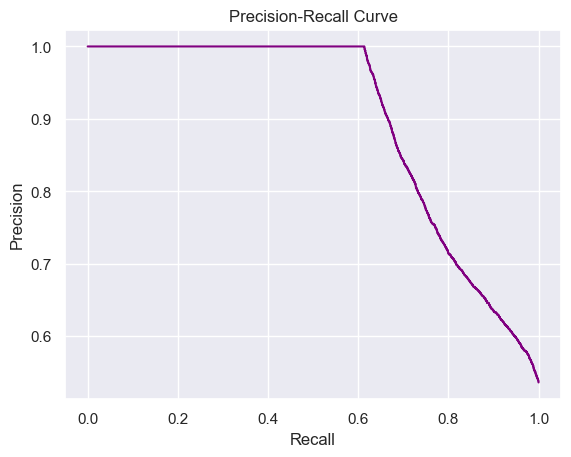

array([0.53630626, 0.53633378, 0.5363613 , ..., 1.        , 1.        ,
       1.        ])

In [298]:
proba = logistic_regr.predict_proba(x_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, proba)

#create precision recall curve
fig, ax = plt.subplots()
ax.plot(recall, precision, color='purple')

#add axis labels to plot
ax.set_title('Precision-Recall Curve')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

#display plot
plt.show()
precision

In [299]:
forest_classifier = RandomForestClassifier(n_estimators=3)
forest_classifier.fit(x_train, y_train)

forest_predict = forest_classifier.predict(x_test)
forest_score = forest_classifier.score(x_test, y_test)
print(forest_score)
forest_predict

0.7968389182531944


array([0, 1, 0, ..., 1, 0, 0])

In [300]:
cnf_matrix = metrics.confusion_matrix(y_test, predict)

cnf_matrix

array([[8968,   68],
       [3999, 6452]])

Text(0.5, 427.9555555555555, 'Predicted label')

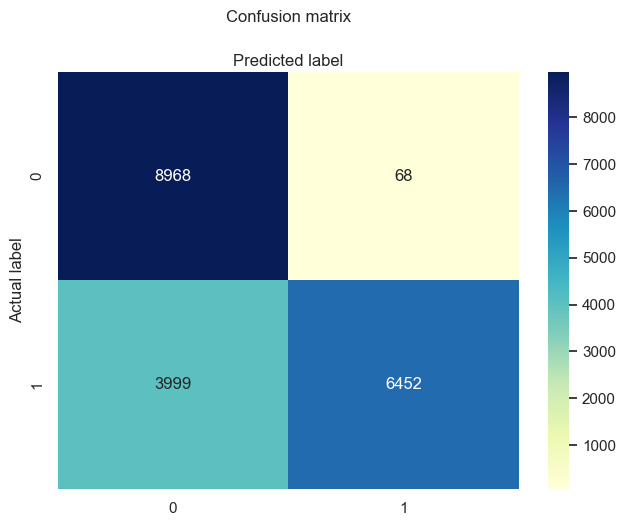

In [301]:
class_names = [0, 1]  # name  of classes

fig, ax = plt.subplots()

tick_marks = np.arange(len(class_names))

plt.xticks(tick_marks, class_names)

plt.yticks(tick_marks, class_names)

# create heatmap

sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu", fmt='g')

ax.xaxis.set_label_position("top")

plt.tight_layout()

plt.title('Confusion matrix', y=1.1)

plt.ylabel('Actual label')

plt.xlabel('Predicted label')

In [302]:
print("Accuracy:", metrics.balanced_accuracy_score(y_test, predict))

print("Precision:", metrics.precision_score(y_test, predict))

print("Recall:", metrics.recall_score(y_test, predict))



Accuracy: 0.8049158684794306
Precision: 0.9895705521472392
Recall: 0.6173571906994546


In [303]:
gv_df_clean.is_injured_or_killed[gv_df_clean['is_injured_or_killed'] == 0]

10359     0
79032     0
21200     0
62759     0
220693    0
         ..
27588     0
148374    0
171007    0
109586    0
78456     0
Name: is_injured_or_killed, Length: 36435, dtype: int64

In [304]:
print(f1_score(y_test, predict))

0.7603559012432974


array([[<AxesSubplot:title={'center':'state_code'}>]], dtype=object)

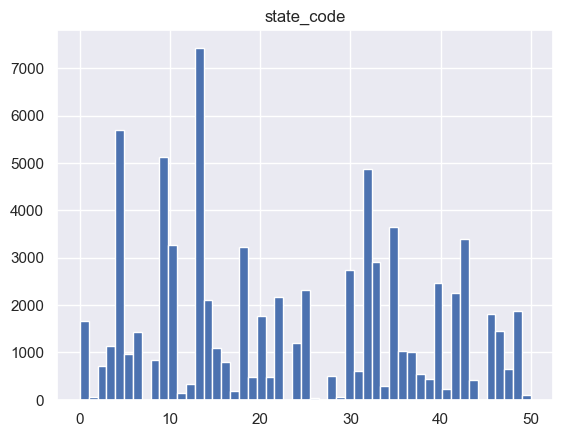

In [305]:
gv_df_clean.hist(column='state_code', bins=51)

65.88025088053703


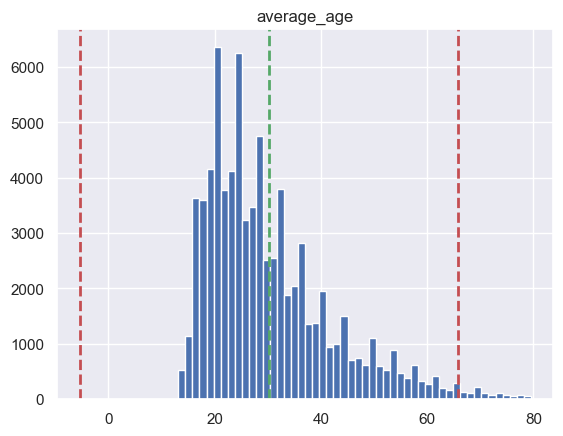

In [306]:
sqrt_gv_df_clean = (gv_df_clean)

sqrt_gv_df_clean.hist(column='average_age', bins=50)

mean = sqrt_gv_df_clean['average_age'].mean()
std = np.std(sqrt_gv_df_clean['average_age'])

plt.axvline(mean, color='g', linestyle='dashed', linewidth=2)
plt.axvline(mean - 3 * std, color='r', linestyle='dashed', linewidth=2)
plt.axvline(mean + 3 * std, color='r', linestyle='dashed', linewidth=2)
print(mean + 3 * std)

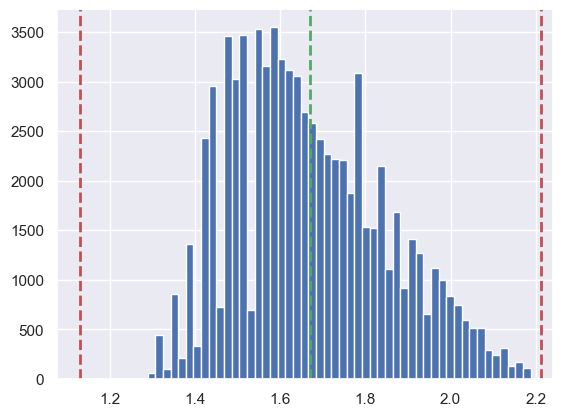

In [307]:
sqrt_gv_df_age = np.log(np.sqrt(gv_df_clean['average_age']))

sqrt_gv_df_age.hist(bins=50)
mean = sqrt_gv_df_age.mean()
std = np.std(sqrt_gv_df_age)
plt.axvline(mean, color='g', linestyle='dashed', linewidth=2)
plt.axvline(mean - 3 * std, color='r', linestyle='dashed', linewidth=2)
plt.axvline(mean + 3 * std, color='r', linestyle='dashed', linewidth=2)

In [308]:
print(f"Meadian of average age:               {gv_df_clean['average_age'].median()}")
print(f"Mean of average age:                  {gv_df_clean['average_age'].mean()}")
print(f"Dispertion of average age:            {np.var(gv_df_clean['average_age'])}")
print(f"Standard deviation of average age:    {np.std(gv_df_clean['average_age'])}")
print("--------------------------------------")
print(f"Meadian of state:                     {gv_df_clean['state_code'].median()}")
print(f"Mean of state:                        {gv_df_clean['state_code'].mean()}")
print(f"Dispertion of state:                  {np.var(gv_df_clean['state_code'])}")
print(f"Standard deviation of state:          {np.std(gv_df_clean['state_code'])}")


Meadian of average age:               27.0
Mean of average age:                  30.255548916901247
Dispertion of average age:            141.0132655553195
Standard deviation of average age:    11.874900654545263
--------------------------------------
Meadian of state:                     22.0
Mean of state:                        23.138130548570842
Dispertion of state:                  207.03904844747188
Standard deviation of state:          14.388851533304244


In [309]:
gv_df_clean['sqrt_age'] = np.log(np.sqrt(gv_df_clean['average_age']))

gv_df_clean = shuffle(gv_df_clean)

data_columns = ['state_code', 'average_age', 'gender_bool',
                'year', 'month', 'day',
                'city_code', 'is_injured', 'state_house_district',
                'state_senate_district', 'congressional_district',
                'latitude', 'longitude', 'sqrt_age']

df_target = gv_df_clean.is_injured_or_killed
df_data = gv_df_clean[data_columns]
x_train, x_test, y_train, y_test = train_test_split(df_data, df_target, test_size=0.25, random_state=0)

In [310]:
logistic_regr = LogisticRegression(solver='newton-cg',#, class_weight='balanced',
 max_iter=150)

logistic_regr.fit(x_train, y_train)

predict = logistic_regr.predict(x_test)
y_score = logistic_regr.score(x_test, y_test)

print(y_score)
predict

/Users/denisserbin/PycharmProjects/nmla_lab1_serbin/venv/lib/python3.8/site-packages/scipy/optimize/_linesearch.py:456: LineSearchWarning:

The line search algorithm did not converge

/Users/denisserbin/PycharmProjects/nmla_lab1_serbin/venv/lib/python3.8/site-packages/scipy/optimize/_linesearch.py:305: LineSearchWarning:

The line search algorithm did not converge



0.7913480782059835


/Users/denisserbin/PycharmProjects/nmla_lab1_serbin/venv/lib/python3.8/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning:

newton-cg failed to converge. Increase the number of iterations.



array([0, 0, 1, ..., 0, 0, 1])

In [311]:
forest_classifier = RandomForestClassifier(n_estimators=3)
forest_classifier.fit(x_train, y_train)

forest_predict = forest_classifier.predict(x_test)
forest_score = forest_classifier.score(x_test, y_test)
print(forest_score)
forest_predict

0.7948375840303792


array([0, 0, 1, ..., 0, 1, 1])

In [312]:
cnf_matrix = metrics.confusion_matrix(y_test, predict)

cnf_matrix

array([[8904,  114],
       [3952, 6517]])

Text(0.5, 427.9555555555555, 'Predicted label')

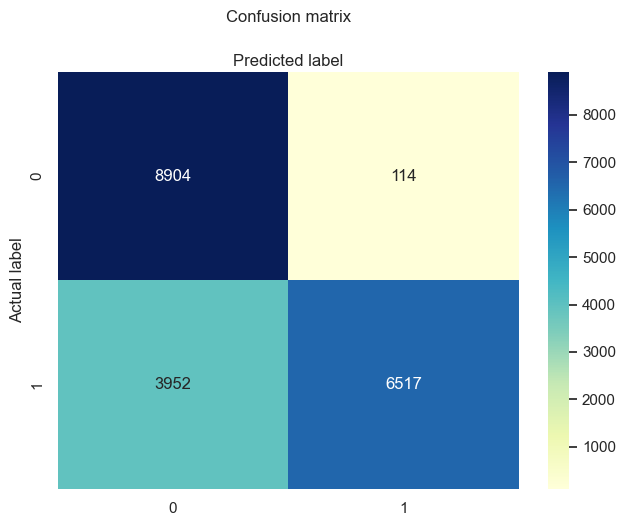

In [313]:
class_names = [0, 1]  # name  of classes

fig, ax = plt.subplots()

tick_marks = np.arange(len(class_names))

plt.xticks(tick_marks, class_names)

plt.yticks(tick_marks, class_names)

# create heatmap

sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu", fmt='g')

ax.xaxis.set_label_position("top")

plt.tight_layout()

plt.title('Confusion matrix', y=1.1)

plt.ylabel('Actual label')

plt.xlabel('Predicted label')

In [314]:
print("Accuracy:", metrics.balanced_accuracy_score(y_test, predict))

print("Precision:", metrics.precision_score(y_test, predict))

print("Recall:", metrics.recall_score(y_test, predict))

Accuracy: 0.8049315766531064
Precision: 0.9828080229226361
Recall: 0.6225045372050817


In [315]:
print(f1_score(y_test, predict))

0.7622222222222222
